
## Avant de commencer le TP, 
- vérifiez que vous êtes sur un environnement GPU et python 3 : 
  
  Éxecution -> Modifier le type d'éxecution -> Type d'éxecution = python2, Accélerateur matériel = GPU

- Fichier -> Sauvegarder une copie dans mon drive

In [10]:
# It will reload all changed modules every time before executing a new line
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/My Drive/git/RDFIA/TME 5-6")
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
'cours a.pdf'		       'Rapport TME 5-6.docx'
'cours b.pdf'		        TP_5_6_CNN_Deep_Learning_Sorbonne.ipynb
'cours c.pdf'		        tp5-6.pdf
 deep-learning-polytech-tp6-7  '~WRL0003.tmp'
'~$pport TME 5-6.docx'


In [12]:
!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git

fatal: destination path 'deep-learning-polytech-tp6-7' already exists and is not an empty directory.


In [13]:
cd deep-learning-polytech-tp6-7

/content/gdrive/My Drive/git/RDFIA/TME 5-6/deep-learning-polytech-tp6-7


In [14]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tme6 import *

PRINT_INTERVAL = 200
PATH="datasets"

In [15]:
class ConvNet(nn.Module):
    """
    Cette classe contient la structure du réseau de neurones
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # On défini d'abord les couches de convolution et de pooling comme un
        # groupe de couches `self.features`
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, (5, 5), stride=1, padding=2),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # On défini les couches fully connected comme un groupe de couches
        # `self.classifier`
        self.classifier = nn.Sequential(
            nn.Linear(400, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
            # Rappel : Le softmax est inclus dans la loss, ne pas le mettre ici
        )

    # méthode appelée quand on applique le réseau à un batch d'input
    def forward(self, input):
        bsize = input.size(0) # taille du batch
        output = self.features(input) # on calcule la sortie des conv
        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input
        output = self.classifier(output) # on calcule la sortie des fc
        return output



def get_dataset(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et effectue des transformations sur chaqu
    image (listées dans `transform=...`).
    """
    train_dataset = datasets.MNIST(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.MNIST(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # si on fait du GPU, passage en CUDA
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex de params :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # On récupère les données
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Phase d'evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


=== EPOCH 1 =====

[TRAIN Batch 000/469]	Time 0.124s (0.124s)	Loss 2.3067 (2.3067)	Prec@1  10.9 ( 10.9)	Prec@5  52.3 ( 52.3)


<Figure size 432x288 with 0 Axes>

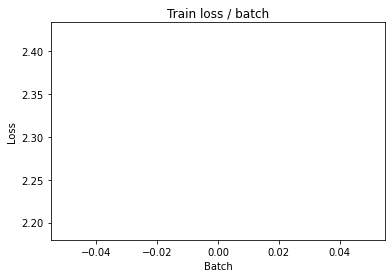

[TRAIN Batch 200/469]	Time 0.026s (0.014s)	Loss 0.2919 (1.0768)	Prec@1  89.8 ( 69.6)	Prec@5 100.0 ( 93.2)


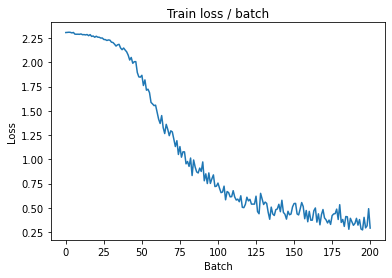

[TRAIN Batch 400/469]	Time 0.021s (0.013s)	Loss 0.2156 (0.6627)	Prec@1  93.8 ( 81.2)	Prec@5  99.2 ( 96.4)


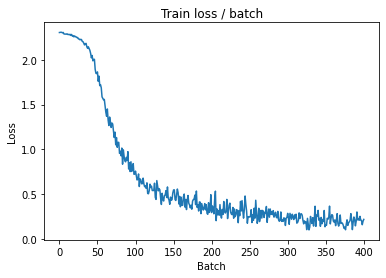


===============> Total time 6s	Avg loss 0.5900	Avg Prec@1 83.23 %	Avg Prec@5 96.93 %

[EVAL Batch 000/079]	Time 0.115s (0.115s)	Loss 0.0813 (0.0813)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)

===============> Total time 0s	Avg loss 0.1427	Avg Prec@1 95.83 %	Avg Prec@5 99.97 %



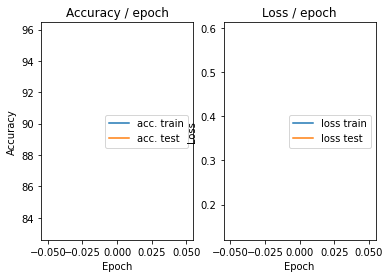

=== EPOCH 2 =====

[TRAIN Batch 000/469]	Time 0.109s (0.109s)	Loss 0.1369 (0.1369)	Prec@1  95.3 ( 95.3)	Prec@5 100.0 (100.0)


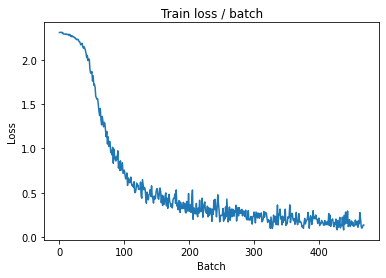

[TRAIN Batch 200/469]	Time 0.019s (0.013s)	Loss 0.1760 (0.1311)	Prec@1  93.0 ( 96.1)	Prec@5 100.0 ( 99.9)


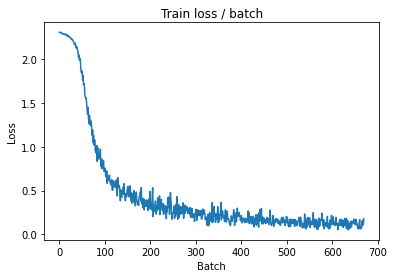

[TRAIN Batch 400/469]	Time 0.018s (0.013s)	Loss 0.0523 (0.1193)	Prec@1  98.4 ( 96.4)	Prec@5 100.0 ( 99.9)


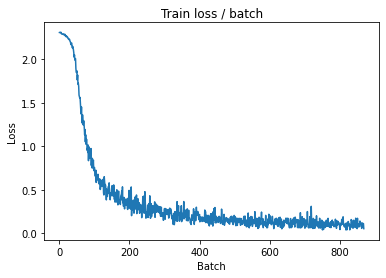


===============> Total time 6s	Avg loss 0.1159	Avg Prec@1 96.55 %	Avg Prec@5 99.92 %

[EVAL Batch 000/079]	Time 0.118s (0.118s)	Loss 0.0314 (0.0314)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)

===============> Total time 0s	Avg loss 0.0751	Avg Prec@1 97.81 %	Avg Prec@5 100.00 %



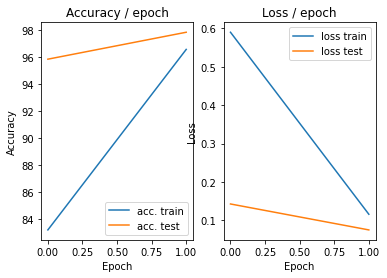

=== EPOCH 3 =====

[TRAIN Batch 000/469]	Time 0.123s (0.123s)	Loss 0.0831 (0.0831)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


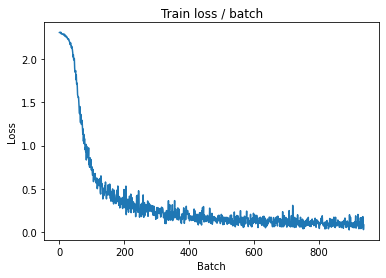

[TRAIN Batch 200/469]	Time 0.004s (0.013s)	Loss 0.0694 (0.0814)	Prec@1  98.4 ( 97.6)	Prec@5 100.0 ( 99.9)


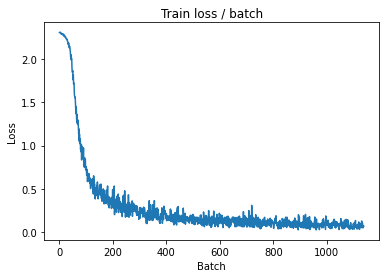

[TRAIN Batch 400/469]	Time 0.019s (0.013s)	Loss 0.0514 (0.0788)	Prec@1  98.4 ( 97.6)	Prec@5 100.0 (100.0)


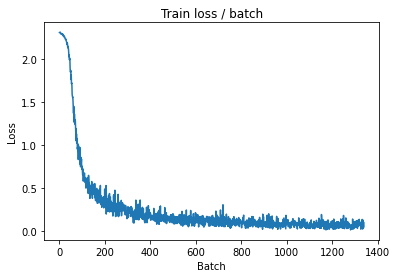


===============> Total time 5s	Avg loss 0.0775	Avg Prec@1 97.66 %	Avg Prec@5 99.95 %

[EVAL Batch 000/079]	Time 0.111s (0.111s)	Loss 0.0209 (0.0209)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 0s	Avg loss 0.0561	Avg Prec@1 98.37 %	Avg Prec@5 99.99 %



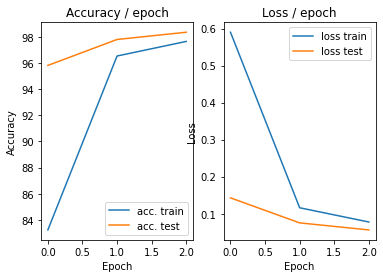

=== EPOCH 4 =====

[TRAIN Batch 000/469]	Time 0.116s (0.116s)	Loss 0.1117 (0.1117)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


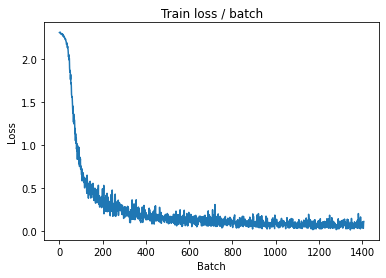

[TRAIN Batch 200/469]	Time 0.004s (0.013s)	Loss 0.0429 (0.0654)	Prec@1  98.4 ( 98.1)	Prec@5 100.0 (100.0)


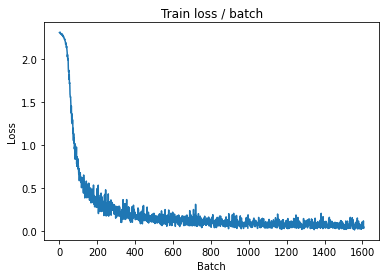

[TRAIN Batch 400/469]	Time 0.018s (0.013s)	Loss 0.0331 (0.0624)	Prec@1  99.2 ( 98.1)	Prec@5 100.0 (100.0)


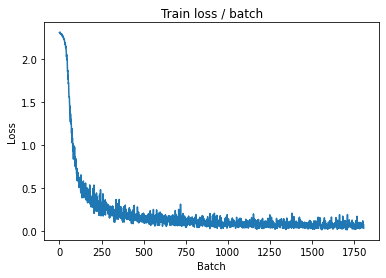


===============> Total time 6s	Avg loss 0.0615	Avg Prec@1 98.16 %	Avg Prec@5 99.97 %

[EVAL Batch 000/079]	Time 0.110s (0.110s)	Loss 0.0113 (0.0113)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 0s	Avg loss 0.0476	Avg Prec@1 98.57 %	Avg Prec@5 100.00 %



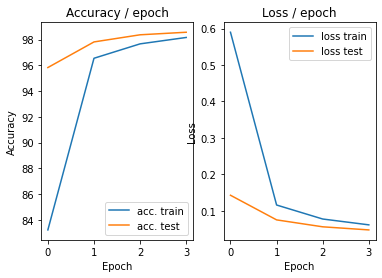

=== EPOCH 5 =====

[TRAIN Batch 000/469]	Time 0.117s (0.117s)	Loss 0.0752 (0.0752)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


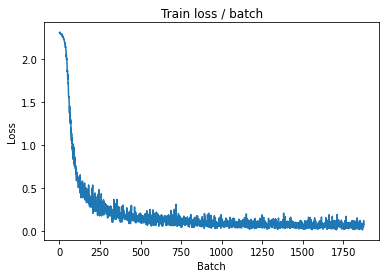

[TRAIN Batch 200/469]	Time 0.004s (0.013s)	Loss 0.0266 (0.0514)	Prec@1  99.2 ( 98.5)	Prec@5 100.0 (100.0)


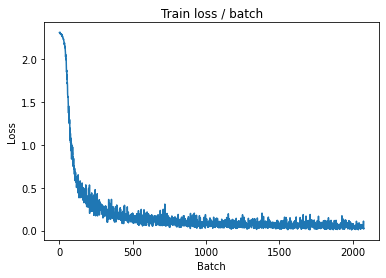

[TRAIN Batch 400/469]	Time 0.003s (0.013s)	Loss 0.0510 (0.0517)	Prec@1  97.7 ( 98.5)	Prec@5 100.0 (100.0)


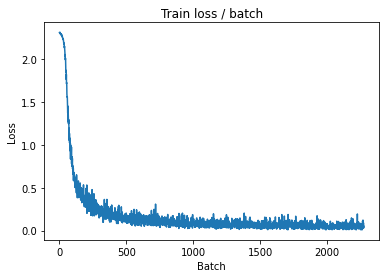


===============> Total time 5s	Avg loss 0.0514	Avg Prec@1 98.49 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.107s (0.107s)	Loss 0.0148 (0.0148)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 0s	Avg loss 0.0416	Avg Prec@1 98.58 %	Avg Prec@5 100.00 %



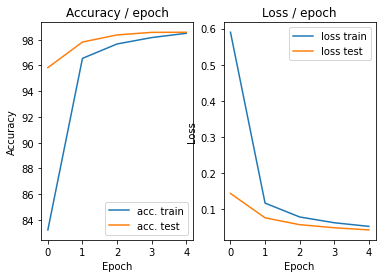

In [16]:
main(128, 0.1, cuda=True)

### Modifiez le code pour utiliser la base CIFAR-10 et implémenter l’architecture demandée ci-dessus. (la classe est datasets.CIFAR10 ). 
### Attention à bien faire suffisament d’epoques pour que le modèle ait fini de converger.

remplacer MNIST par CIFAR10 dans dataset

In [22]:
class ConvNet2(nn.Module):
    """
    Cette classe contient la structure du réseau de neurones
    """

    def __init__(self):
        super(ConvNet2, self).__init__()
        # On défini d'abord les couches de convolution et de pooling comme un
        # groupe de couches `self.features`
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # On défini les couches fully connected comme un groupe de couches
        # `self.classifier`
        self.classifier = nn.Sequential(
            nn.Linear(4*4*64, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Rappel : Le softmax est inclus dans la loss, ne pas le mettre ici
        )

    # méthode appelée quand on applique le réseau à un batch d'input
    def forward(self, input):
        bsize = input.size(0) # taille du batch
        output = self.features(input) # on calcule la sortie des conv

        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input

        output = self.classifier(output) # on calcule la sortie des fc
        return output



def get_dataset(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et effectue des transformations sur chaqu
    image (listées dans `transform=...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # si on fait du GPU, passage en CUDA
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss

def main2(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex de params :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet2()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # On récupère les données
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Phase d'evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.144s (0.144s)	Loss 2.3008 (2.3008)	Prec@1  14.1 ( 14.1)	Prec@5  50.8 ( 50.8)


<Figure size 432x288 with 0 Axes>

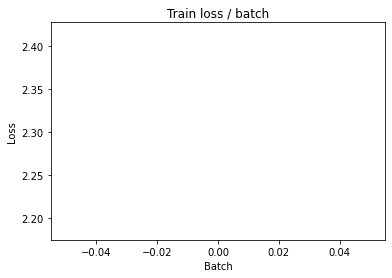

[TRAIN Batch 200/391]	Time 0.027s (0.018s)	Loss 2.2750 (2.2817)	Prec@1  11.7 ( 12.9)	Prec@5  54.7 ( 57.1)


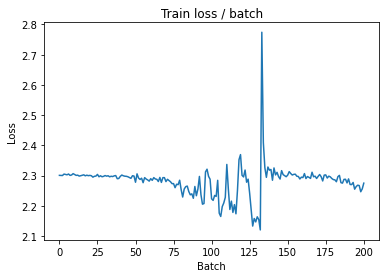


===============> Total time 6s	Avg loss 2.2155	Avg Prec@1 17.06 %	Avg Prec@5 63.77 %

[EVAL Batch 000/079]	Time 0.119s (0.119s)	Loss 1.8682 (1.8682)	Prec@1  40.6 ( 40.6)	Prec@5  82.0 ( 82.0)

===============> Total time 1s	Avg loss 1.8989	Avg Prec@1 32.51 %	Avg Prec@5 82.05 %



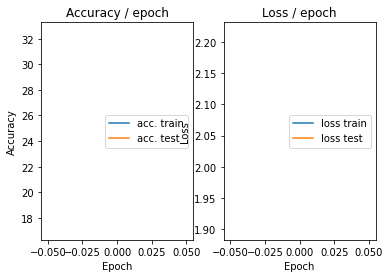

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.127s (0.127s)	Loss 1.8944 (1.8944)	Prec@1  29.7 ( 29.7)	Prec@5  81.2 ( 81.2)


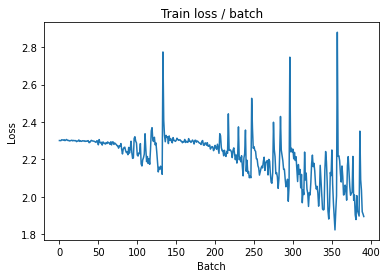

[TRAIN Batch 200/391]	Time 0.027s (0.018s)	Loss 1.8086 (1.8488)	Prec@1  37.5 ( 33.0)	Prec@5  87.5 ( 84.1)


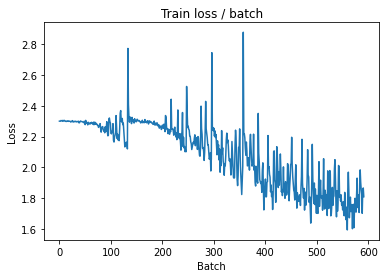


===============> Total time 6s	Avg loss 1.7517	Avg Prec@1 36.40 %	Avg Prec@5 86.37 %

[EVAL Batch 000/079]	Time 0.131s (0.131s)	Loss 1.5105 (1.5105)	Prec@1  45.3 ( 45.3)	Prec@5  93.0 ( 93.0)

===============> Total time 1s	Avg loss 1.5349	Avg Prec@1 43.84 %	Avg Prec@5 91.31 %



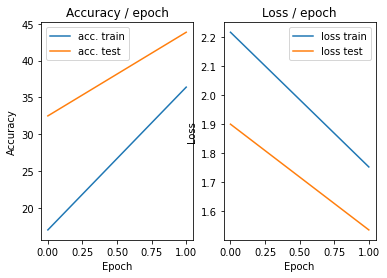

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.131s (0.131s)	Loss 1.4167 (1.4167)	Prec@1  45.3 ( 45.3)	Prec@5  90.6 ( 90.6)


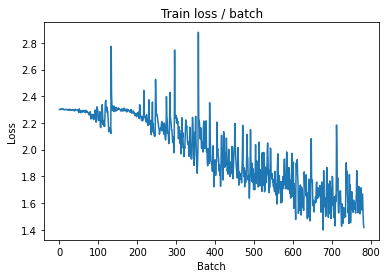

[TRAIN Batch 200/391]	Time 0.010s (0.018s)	Loss 1.3798 (1.5342)	Prec@1  48.4 ( 45.0)	Prec@5  93.8 ( 90.8)


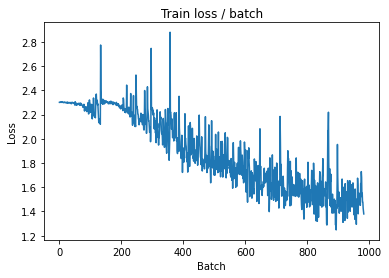


===============> Total time 6s	Avg loss 1.4806	Avg Prec@1 47.09 %	Avg Prec@5 91.63 %

[EVAL Batch 000/079]	Time 0.123s (0.123s)	Loss 1.3290 (1.3290)	Prec@1  55.5 ( 55.5)	Prec@5  93.8 ( 93.8)

===============> Total time 1s	Avg loss 1.4273	Avg Prec@1 48.56 %	Avg Prec@5 92.73 %



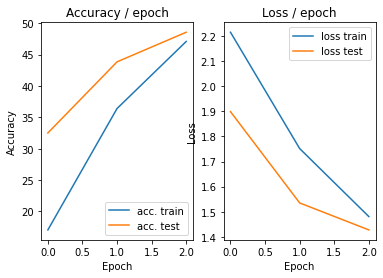

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.132s (0.132s)	Loss 1.2607 (1.2607)	Prec@1  53.9 ( 53.9)	Prec@5  95.3 ( 95.3)


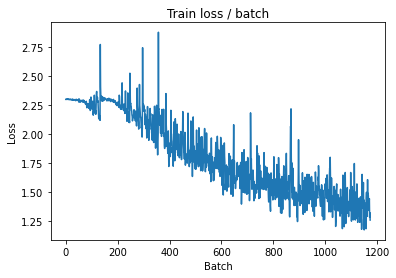

[TRAIN Batch 200/391]	Time 0.015s (0.018s)	Loss 1.3930 (1.3356)	Prec@1  50.8 ( 52.7)	Prec@5  93.8 ( 93.8)


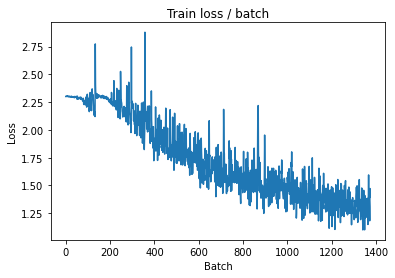


===============> Total time 6s	Avg loss 1.3052	Avg Prec@1 53.52 %	Avg Prec@5 94.15 %

[EVAL Batch 000/079]	Time 0.133s (0.133s)	Loss 1.1053 (1.1053)	Prec@1  59.4 ( 59.4)	Prec@5  94.5 ( 94.5)

===============> Total time 1s	Avg loss 1.2791	Avg Prec@1 53.51 %	Avg Prec@5 94.52 %



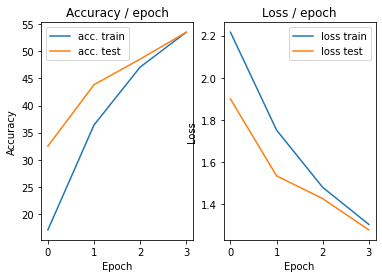

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.128s (0.128s)	Loss 1.0855 (1.0855)	Prec@1  64.1 ( 64.1)	Prec@5  94.5 ( 94.5)


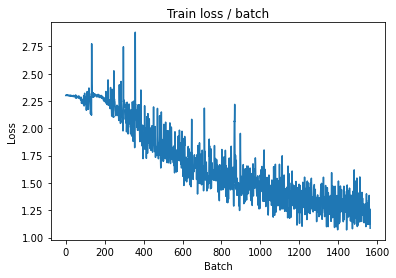

[TRAIN Batch 200/391]	Time 0.011s (0.019s)	Loss 0.9481 (1.1946)	Prec@1  64.8 ( 57.5)	Prec@5  95.3 ( 95.1)


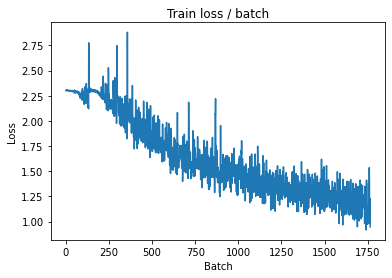


===============> Total time 6s	Avg loss 1.1737	Avg Prec@1 58.29 %	Avg Prec@5 95.31 %

[EVAL Batch 000/079]	Time 0.117s (0.117s)	Loss 0.9877 (0.9877)	Prec@1  67.2 ( 67.2)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.1418	Avg Prec@1 59.24 %	Avg Prec@5 95.59 %



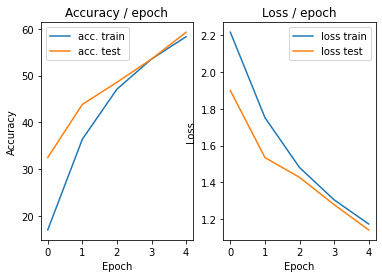

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.134s (0.134s)	Loss 1.0843 (1.0843)	Prec@1  60.2 ( 60.2)	Prec@5  96.1 ( 96.1)


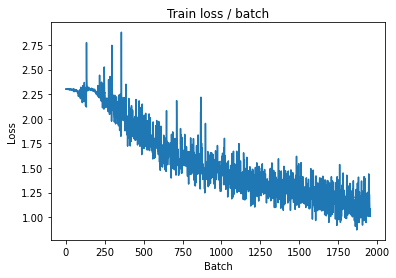

[TRAIN Batch 200/391]	Time 0.022s (0.019s)	Loss 1.0733 (1.0640)	Prec@1  60.9 ( 62.3)	Prec@5  97.7 ( 96.3)


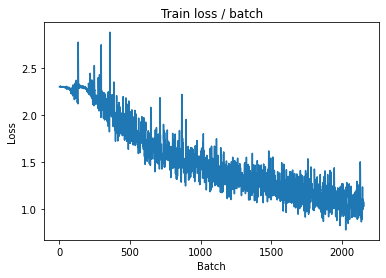


===============> Total time 7s	Avg loss 1.0451	Avg Prec@1 63.13 %	Avg Prec@5 96.51 %

[EVAL Batch 000/079]	Time 0.119s (0.119s)	Loss 0.9555 (0.9555)	Prec@1  68.8 ( 68.8)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.0726	Avg Prec@1 62.85 %	Avg Prec@5 96.16 %



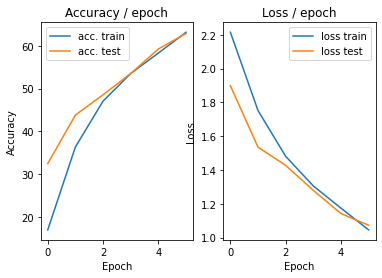

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.141s (0.141s)	Loss 0.9999 (0.9999)	Prec@1  66.4 ( 66.4)	Prec@5 100.0 (100.0)


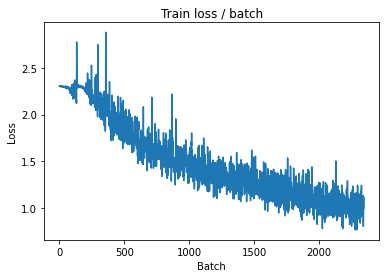

[TRAIN Batch 200/391]	Time 0.013s (0.018s)	Loss 0.9682 (0.9477)	Prec@1  68.8 ( 66.5)	Prec@5  99.2 ( 97.2)


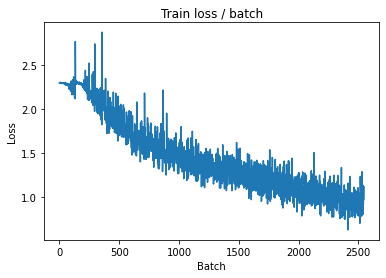


===============> Total time 6s	Avg loss 0.9372	Avg Prec@1 66.88 %	Avg Prec@5 97.28 %

[EVAL Batch 000/079]	Time 0.119s (0.119s)	Loss 0.9211 (0.9211)	Prec@1  68.0 ( 68.0)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.0310	Avg Prec@1 63.96 %	Avg Prec@5 96.60 %



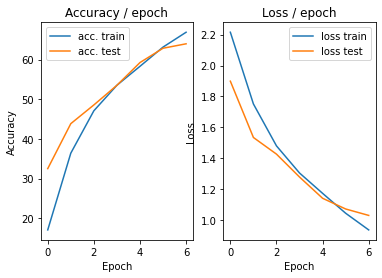

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.151s (0.151s)	Loss 0.9372 (0.9372)	Prec@1  66.4 ( 66.4)	Prec@5  96.9 ( 96.9)


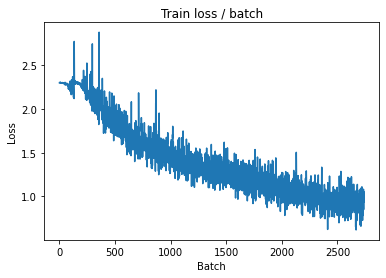

[TRAIN Batch 200/391]	Time 0.028s (0.017s)	Loss 0.8304 (0.8244)	Prec@1  69.5 ( 71.4)	Prec@5  99.2 ( 97.9)


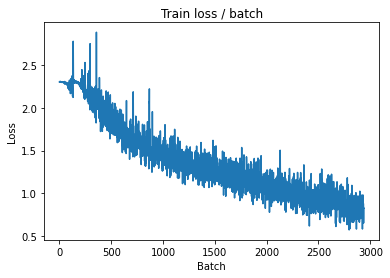


===============> Total time 6s	Avg loss 0.8290	Avg Prec@1 71.00 %	Avg Prec@5 97.92 %

[EVAL Batch 000/079]	Time 0.122s (0.122s)	Loss 0.9081 (0.9081)	Prec@1  70.3 ( 70.3)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 0.9582	Avg Prec@1 66.73 %	Avg Prec@5 96.83 %



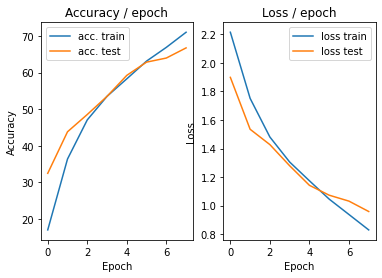

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.127s (0.127s)	Loss 0.6040 (0.6040)	Prec@1  78.1 ( 78.1)	Prec@5  99.2 ( 99.2)


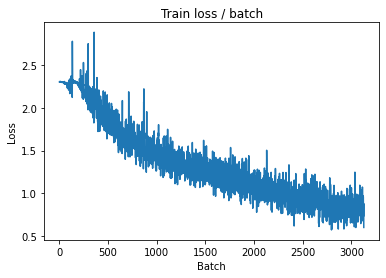

[TRAIN Batch 200/391]	Time 0.012s (0.018s)	Loss 0.6579 (0.7359)	Prec@1  79.7 ( 74.2)	Prec@5  97.7 ( 98.5)


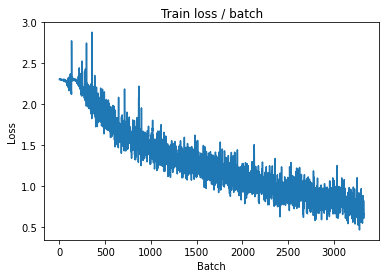


===============> Total time 7s	Avg loss 0.7334	Avg Prec@1 74.41 %	Avg Prec@5 98.44 %

[EVAL Batch 000/079]	Time 0.127s (0.127s)	Loss 0.8481 (0.8481)	Prec@1  71.1 ( 71.1)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 1.0220	Avg Prec@1 65.68 %	Avg Prec@5 96.79 %



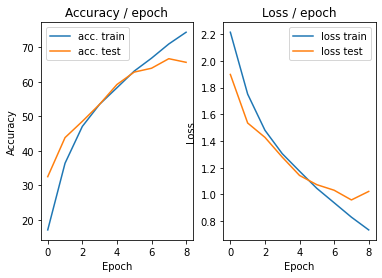

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.144s (0.144s)	Loss 0.7496 (0.7496)	Prec@1  74.2 ( 74.2)	Prec@5  97.7 ( 97.7)


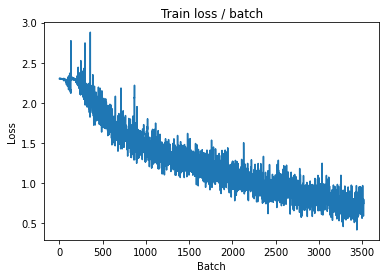

[TRAIN Batch 200/391]	Time 0.019s (0.019s)	Loss 0.5221 (0.6346)	Prec@1  77.3 ( 77.9)	Prec@5  99.2 ( 98.8)


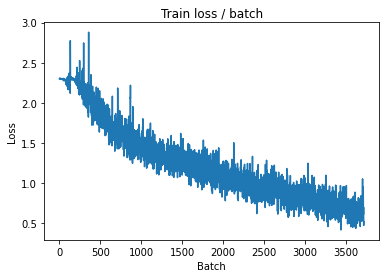


===============> Total time 7s	Avg loss 0.6349	Avg Prec@1 77.77 %	Avg Prec@5 98.83 %

[EVAL Batch 000/079]	Time 0.109s (0.109s)	Loss 1.0103 (1.0103)	Prec@1  61.7 ( 61.7)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.0008	Avg Prec@1 66.21 %	Avg Prec@5 97.16 %



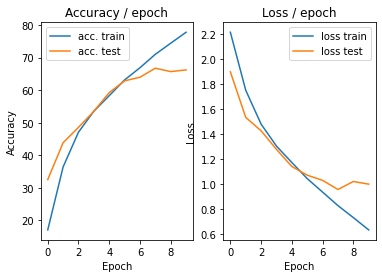

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.129s (0.129s)	Loss 0.4941 (0.4941)	Prec@1  83.6 ( 83.6)	Prec@5  99.2 ( 99.2)


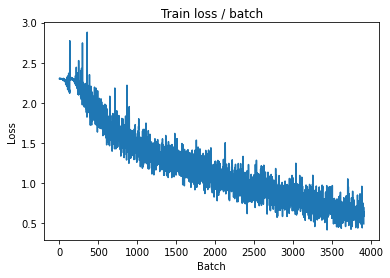

[TRAIN Batch 200/391]	Time 0.012s (0.018s)	Loss 0.4972 (0.5402)	Prec@1  85.9 ( 81.3)	Prec@5 100.0 ( 99.3)


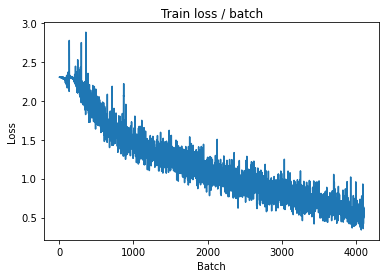


===============> Total time 6s	Avg loss 0.5466	Avg Prec@1 81.01 %	Avg Prec@5 99.32 %

[EVAL Batch 000/079]	Time 0.147s (0.147s)	Loss 1.0209 (1.0209)	Prec@1  68.8 ( 68.8)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 0.9832	Avg Prec@1 68.15 %	Avg Prec@5 97.09 %



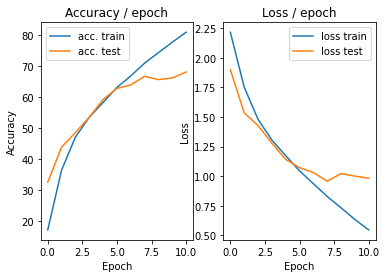

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.132s (0.132s)	Loss 0.3932 (0.3932)	Prec@1  86.7 ( 86.7)	Prec@5 100.0 (100.0)


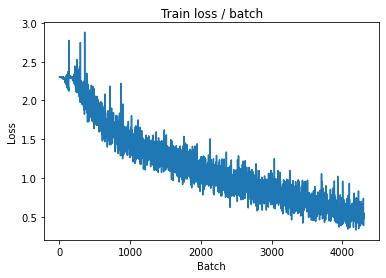

[TRAIN Batch 200/391]	Time 0.028s (0.019s)	Loss 0.5679 (0.4330)	Prec@1  80.5 ( 84.9)	Prec@5  99.2 ( 99.6)


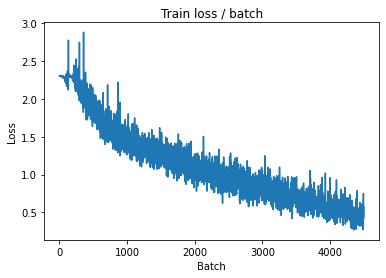


===============> Total time 7s	Avg loss 0.4496	Avg Prec@1 84.28 %	Avg Prec@5 99.55 %

[EVAL Batch 000/079]	Time 0.131s (0.131s)	Loss 0.9401 (0.9401)	Prec@1  70.3 ( 70.3)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.0011	Avg Prec@1 68.80 %	Avg Prec@5 97.12 %



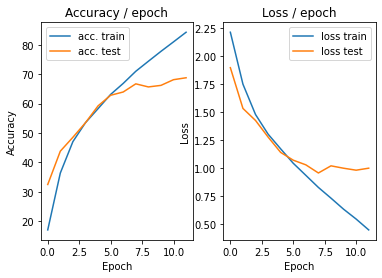

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.142s (0.142s)	Loss 0.4960 (0.4960)	Prec@1  84.4 ( 84.4)	Prec@5 100.0 (100.0)


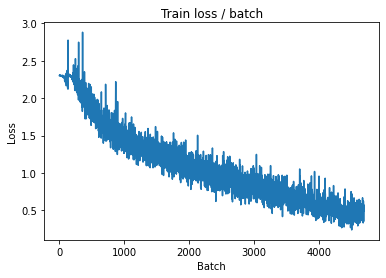

[TRAIN Batch 200/391]	Time 0.033s (0.019s)	Loss 0.2859 (0.3282)	Prec@1  89.8 ( 88.7)	Prec@5 100.0 ( 99.8)


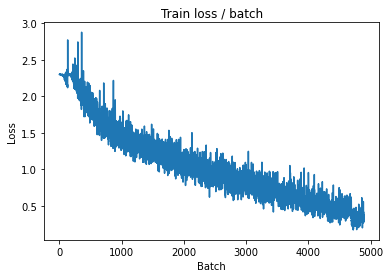


===============> Total time 7s	Avg loss 0.3473	Avg Prec@1 87.91 %	Avg Prec@5 99.77 %

[EVAL Batch 000/079]	Time 0.130s (0.130s)	Loss 1.0966 (1.0966)	Prec@1  69.5 ( 69.5)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.1828	Avg Prec@1 66.10 %	Avg Prec@5 96.69 %



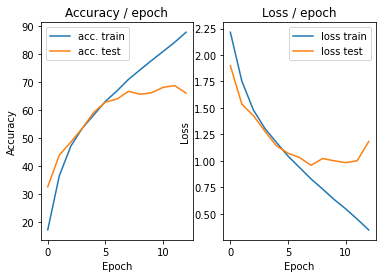

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.130s (0.130s)	Loss 0.4905 (0.4905)	Prec@1  84.4 ( 84.4)	Prec@5  99.2 ( 99.2)


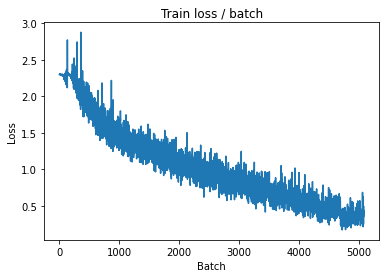

[TRAIN Batch 200/391]	Time 0.009s (0.018s)	Loss 0.2816 (0.2620)	Prec@1  89.8 ( 91.1)	Prec@5 100.0 ( 99.9)


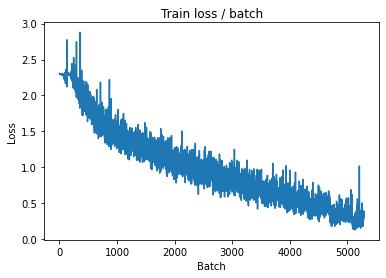


===============> Total time 7s	Avg loss 0.2789	Avg Prec@1 90.34 %	Avg Prec@5 99.89 %

[EVAL Batch 000/079]	Time 0.125s (0.125s)	Loss 1.1392 (1.1392)	Prec@1  70.3 ( 70.3)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.1141	Avg Prec@1 69.40 %	Avg Prec@5 97.48 %



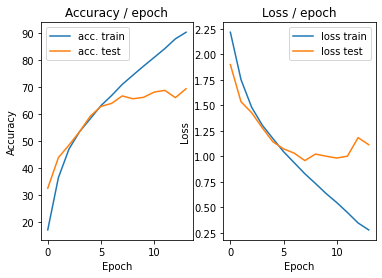

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.147s (0.147s)	Loss 0.1449 (0.1449)	Prec@1  94.5 ( 94.5)	Prec@5 100.0 (100.0)


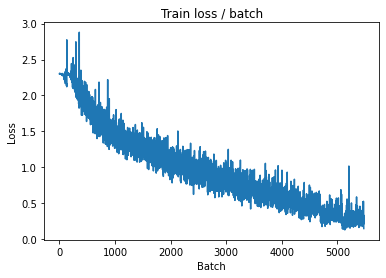

[TRAIN Batch 200/391]	Time 0.012s (0.018s)	Loss 0.1459 (0.1720)	Prec@1  95.3 ( 94.4)	Prec@5 100.0 (100.0)


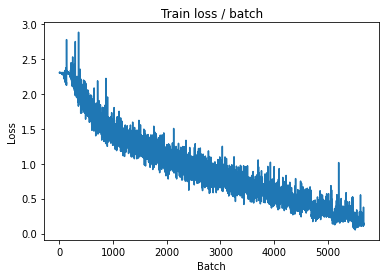


===============> Total time 6s	Avg loss 0.1960	Avg Prec@1 93.42 %	Avg Prec@5 99.95 %

[EVAL Batch 000/079]	Time 0.134s (0.134s)	Loss 1.1144 (1.1144)	Prec@1  71.9 ( 71.9)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.1985	Avg Prec@1 69.46 %	Avg Prec@5 97.14 %



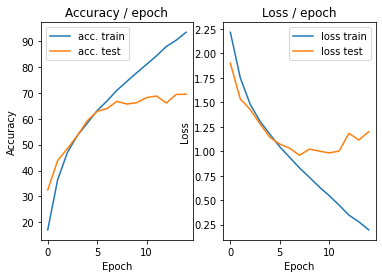

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.135s (0.135s)	Loss 0.1653 (0.1653)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


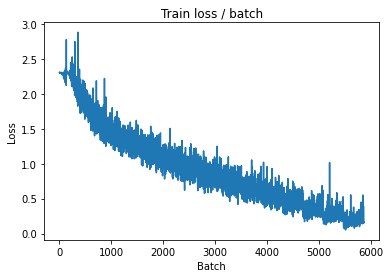

[TRAIN Batch 200/391]	Time 0.022s (0.019s)	Loss 0.1296 (0.1174)	Prec@1  96.1 ( 96.2)	Prec@5 100.0 (100.0)


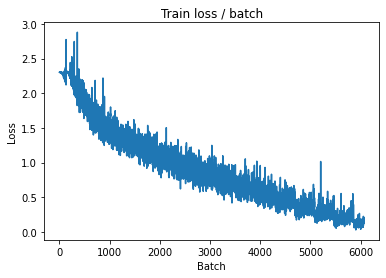


===============> Total time 7s	Avg loss 0.1401	Avg Prec@1 95.30 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.142s (0.142s)	Loss 1.3466 (1.3466)	Prec@1  71.9 ( 71.9)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.4358	Avg Prec@1 68.02 %	Avg Prec@5 96.89 %



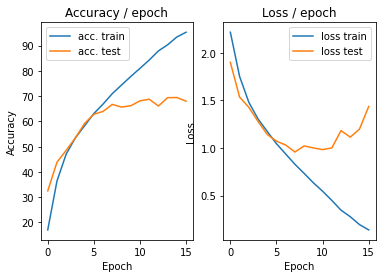

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.138s (0.138s)	Loss 0.1670 (0.1670)	Prec@1  94.5 ( 94.5)	Prec@5 100.0 (100.0)


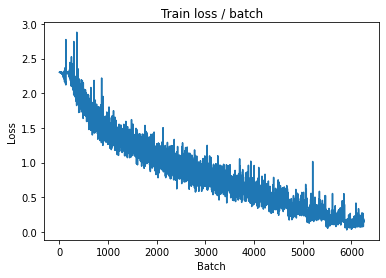

[TRAIN Batch 200/391]	Time 0.021s (0.020s)	Loss 0.0918 (0.0881)	Prec@1  97.7 ( 97.2)	Prec@5 100.0 (100.0)


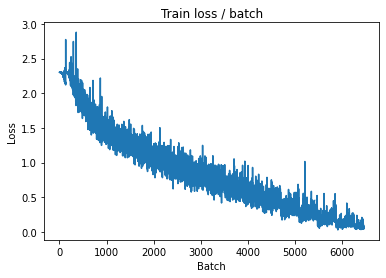


===============> Total time 7s	Avg loss 0.1073	Avg Prec@1 96.57 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.137s (0.137s)	Loss 1.4477 (1.4477)	Prec@1  76.6 ( 76.6)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.3959	Avg Prec@1 70.00 %	Avg Prec@5 97.14 %



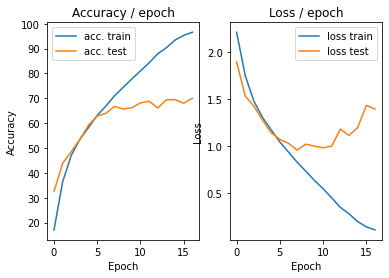

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.133s (0.133s)	Loss 0.1106 (0.1106)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


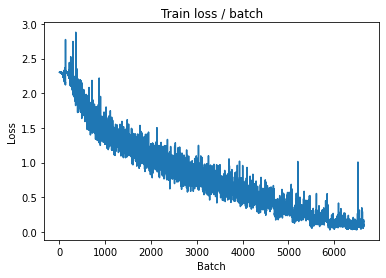

[TRAIN Batch 200/391]	Time 0.031s (0.018s)	Loss 0.1181 (0.0542)	Prec@1  96.1 ( 98.4)	Prec@5 100.0 (100.0)


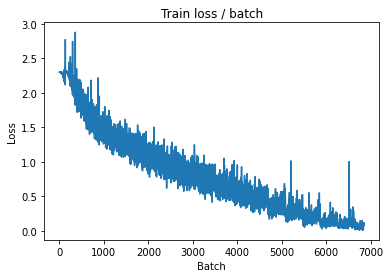


===============> Total time 6s	Avg loss 0.2492	Avg Prec@1 92.85 %	Avg Prec@5 99.53 %

[EVAL Batch 000/079]	Time 0.125s (0.125s)	Loss 1.5938 (1.5938)	Prec@1  65.6 ( 65.6)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.3783	Avg Prec@1 64.39 %	Avg Prec@5 96.59 %



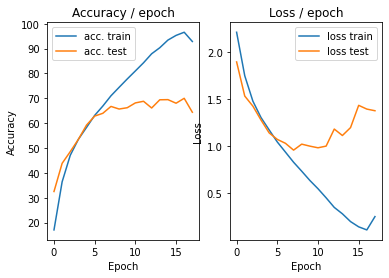

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.139s (0.139s)	Loss 0.4210 (0.4210)	Prec@1  83.6 ( 83.6)	Prec@5 100.0 (100.0)


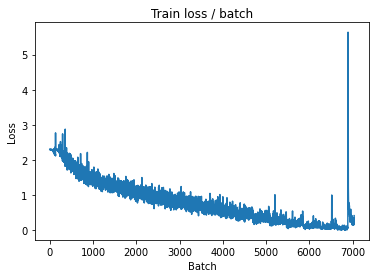

[TRAIN Batch 200/391]	Time 0.020s (0.018s)	Loss 0.1172 (0.1444)	Prec@1  96.1 ( 95.3)	Prec@5 100.0 (100.0)


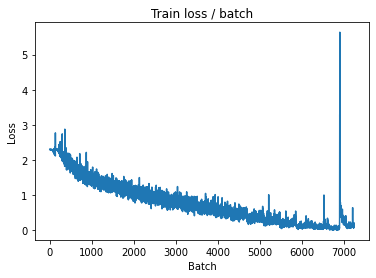


===============> Total time 6s	Avg loss 0.1407	Avg Prec@1 95.37 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.128s (0.128s)	Loss 1.4775 (1.4775)	Prec@1  71.9 ( 71.9)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.5381	Avg Prec@1 69.49 %	Avg Prec@5 96.84 %



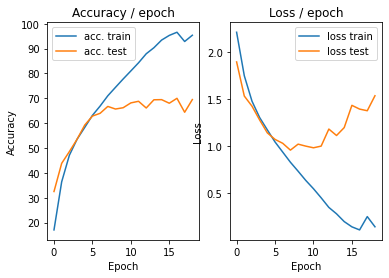

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.144s (0.144s)	Loss 0.0426 (0.0426)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


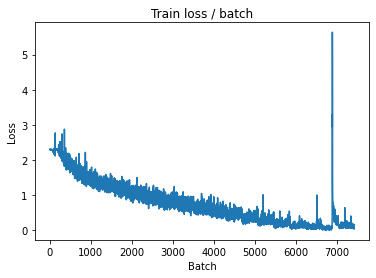

[TRAIN Batch 200/391]	Time 0.013s (0.019s)	Loss 0.0213 (0.0423)	Prec@1 100.0 ( 98.8)	Prec@5 100.0 (100.0)


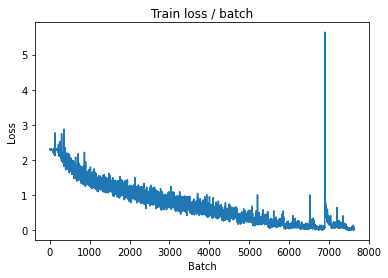


===============> Total time 7s	Avg loss 0.0498	Avg Prec@1 98.46 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.121s (0.121s)	Loss 1.6710 (1.6710)	Prec@1  72.7 ( 72.7)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.6588	Avg Prec@1 68.78 %	Avg Prec@5 96.89 %



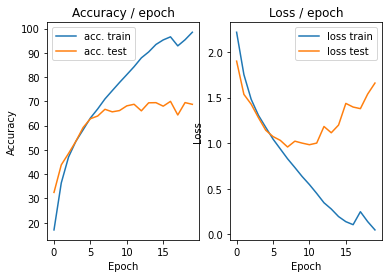

In [23]:
main2(128, 0.1, epochs=20 ,cuda=True)

## Partie 3 – Améliorations des résultats (2 heures)

### 3.1 Normalisation des exemples

In [24]:
class ConvNet3(nn.Module):
    """
    Cette classe contient la structure du réseau de neurones
    """

    def __init__(self):
        super(ConvNet3, self).__init__()
        # On défini d'abord les couches de convolution et de pooling comme un
        # groupe de couches `self.features`
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # On défini les couches fully connected comme un groupe de couches
        # `self.classifier`
        self.classifier = nn.Sequential(
            nn.Linear(4*4*64, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Rappel : Le softmax est inclus dans la loss, ne pas le mettre ici
        )

    # méthode appelée quand on applique le réseau à un batch d'input
    def forward(self, input):
        bsize = input.size(0) # taille du batch
        output = self.features(input) # on calcule la sortie des conv

        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input

        output = self.classifier(output) # on calcule la sortie des fc
        return output



def get_dataset(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et effectue des transformations sur chaqu
    image (listées dans `transform=...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201])
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201])
 
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # si on fait du GPU, passage en CUDA
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss

def main3(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex de params :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet3()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # On récupère les données
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Phase d'evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.175s (0.175s)	Loss 2.3044 (2.3044)	Prec@1   7.8 (  7.8)	Prec@5  46.9 ( 46.9)


<Figure size 432x288 with 0 Axes>

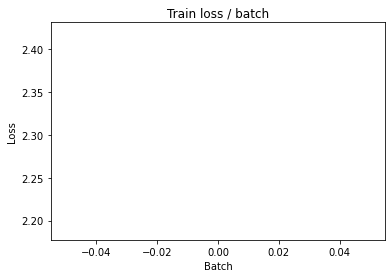

[TRAIN Batch 200/391]	Time 0.036s (0.030s)	Loss 1.5415 (1.9172)	Prec@1  45.3 ( 30.0)	Prec@5  89.8 ( 80.4)


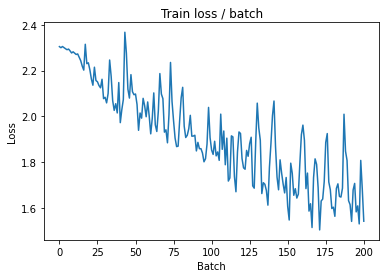


===============> Total time 11s	Avg loss 1.7265	Avg Prec@1 37.30 %	Avg Prec@5 85.67 %

[EVAL Batch 000/079]	Time 0.143s (0.143s)	Loss 1.3705 (1.3705)	Prec@1  55.5 ( 55.5)	Prec@5  90.6 ( 90.6)

===============> Total time 2s	Avg loss 1.3784	Avg Prec@1 49.35 %	Avg Prec@5 93.69 %



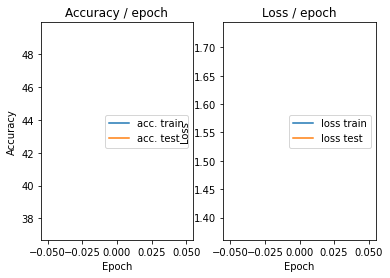

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.148s (0.148s)	Loss 1.3934 (1.3934)	Prec@1  45.3 ( 45.3)	Prec@5  94.5 ( 94.5)


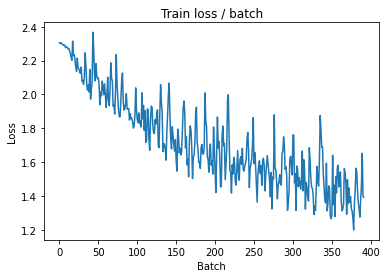

[TRAIN Batch 200/391]	Time 0.032s (0.031s)	Loss 1.3078 (1.3294)	Prec@1  52.3 ( 52.3)	Prec@5  95.3 ( 94.0)


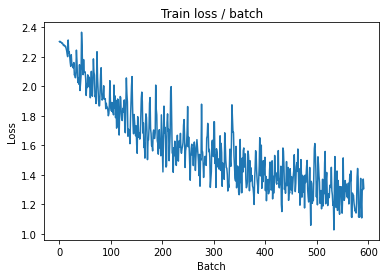


===============> Total time 12s	Avg loss 1.2583	Avg Prec@1 55.28 %	Avg Prec@5 94.72 %

[EVAL Batch 000/079]	Time 0.148s (0.148s)	Loss 1.2067 (1.2067)	Prec@1  58.6 ( 58.6)	Prec@5  93.8 ( 93.8)

===============> Total time 2s	Avg loss 1.2034	Avg Prec@1 57.25 %	Avg Prec@5 94.99 %



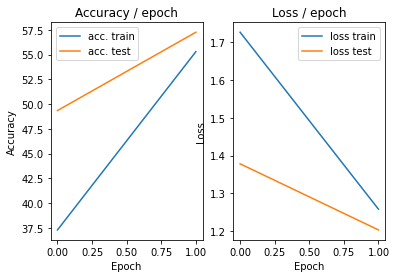

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.162s (0.162s)	Loss 1.0194 (1.0194)	Prec@1  60.9 ( 60.9)	Prec@5  96.1 ( 96.1)


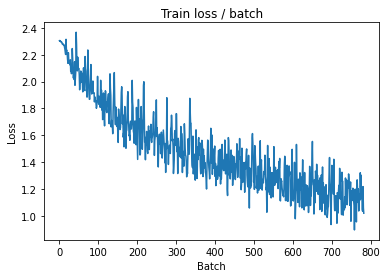

[TRAIN Batch 200/391]	Time 0.017s (0.031s)	Loss 0.9704 (1.0564)	Prec@1  65.6 ( 62.5)	Prec@5  97.7 ( 96.7)


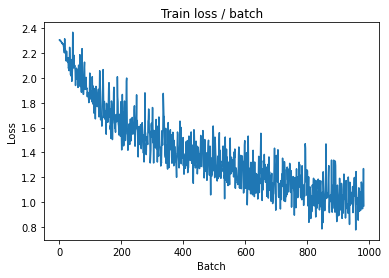


===============> Total time 11s	Avg loss 1.0243	Avg Prec@1 64.06 %	Avg Prec@5 96.73 %

[EVAL Batch 000/079]	Time 0.166s (0.166s)	Loss 1.0340 (1.0340)	Prec@1  62.5 ( 62.5)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 1.0915	Avg Prec@1 61.48 %	Avg Prec@5 96.01 %



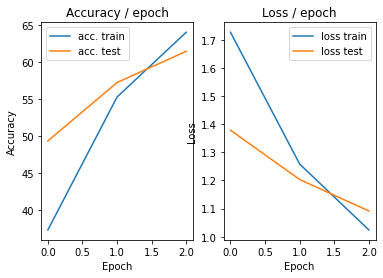

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.161s (0.161s)	Loss 0.9285 (0.9285)	Prec@1  64.1 ( 64.1)	Prec@5  96.9 ( 96.9)


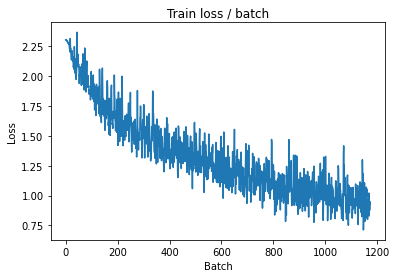

[TRAIN Batch 200/391]	Time 0.050s (0.032s)	Loss 0.7935 (0.8524)	Prec@1  71.1 ( 70.4)	Prec@5  96.9 ( 97.8)


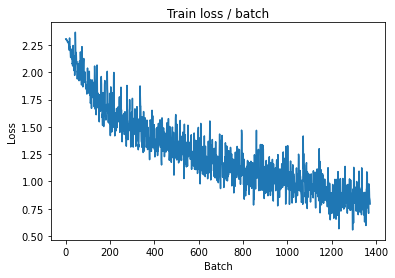


===============> Total time 12s	Avg loss 0.8375	Avg Prec@1 70.96 %	Avg Prec@5 97.83 %

[EVAL Batch 000/079]	Time 0.137s (0.137s)	Loss 0.9220 (0.9220)	Prec@1  71.1 ( 71.1)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.9584	Avg Prec@1 67.05 %	Avg Prec@5 97.06 %



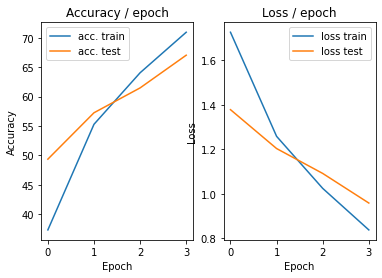

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.153s (0.153s)	Loss 0.9206 (0.9206)	Prec@1  68.0 ( 68.0)	Prec@5  98.4 ( 98.4)


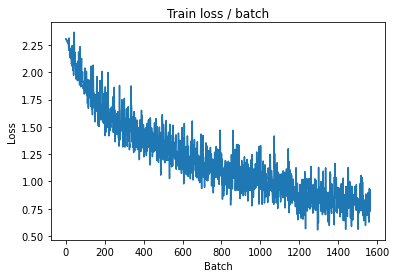

[TRAIN Batch 200/391]	Time 0.014s (0.030s)	Loss 0.8270 (0.7109)	Prec@1  68.8 ( 75.3)	Prec@5  97.7 ( 98.5)


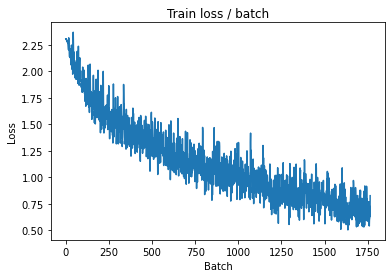


===============> Total time 11s	Avg loss 0.7027	Avg Prec@1 75.54 %	Avg Prec@5 98.46 %

[EVAL Batch 000/079]	Time 0.151s (0.151s)	Loss 0.8354 (0.8354)	Prec@1  71.1 ( 71.1)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.8897	Avg Prec@1 68.56 %	Avg Prec@5 97.64 %



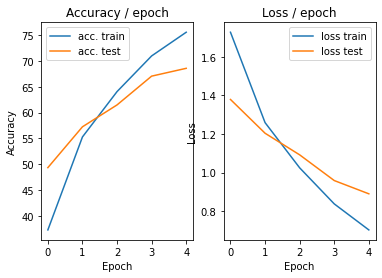

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.153s (0.153s)	Loss 0.5501 (0.5501)	Prec@1  83.6 ( 83.6)	Prec@5  99.2 ( 99.2)


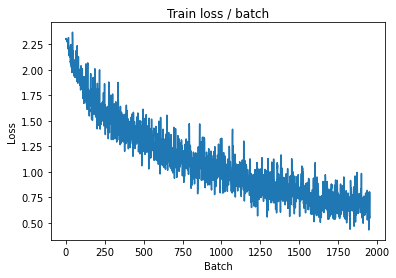

[TRAIN Batch 200/391]	Time 0.038s (0.030s)	Loss 0.4339 (0.5852)	Prec@1  88.3 ( 79.8)	Prec@5 100.0 ( 99.0)


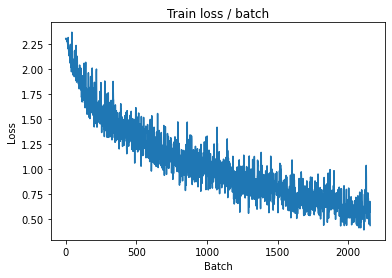


===============> Total time 11s	Avg loss 0.5876	Avg Prec@1 79.52 %	Avg Prec@5 99.05 %

[EVAL Batch 000/079]	Time 0.146s (0.146s)	Loss 0.7675 (0.7675)	Prec@1  72.7 ( 72.7)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.8542	Avg Prec@1 71.68 %	Avg Prec@5 97.83 %



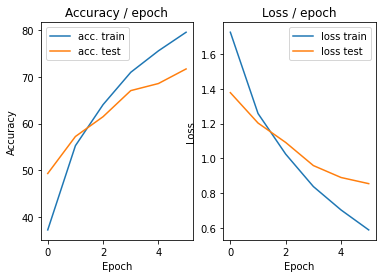

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.158s (0.158s)	Loss 0.4024 (0.4024)	Prec@1  85.9 ( 85.9)	Prec@5  99.2 ( 99.2)


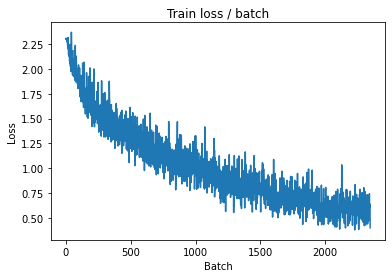

[TRAIN Batch 200/391]	Time 0.029s (0.030s)	Loss 0.5495 (0.4650)	Prec@1  75.8 ( 83.6)	Prec@5  99.2 ( 99.5)


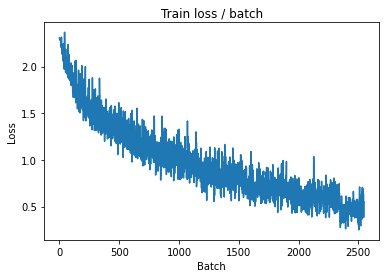


===============> Total time 11s	Avg loss 0.4759	Avg Prec@1 83.30 %	Avg Prec@5 99.45 %

[EVAL Batch 000/079]	Time 0.143s (0.143s)	Loss 0.8375 (0.8375)	Prec@1  74.2 ( 74.2)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.8730	Avg Prec@1 70.33 %	Avg Prec@5 97.67 %



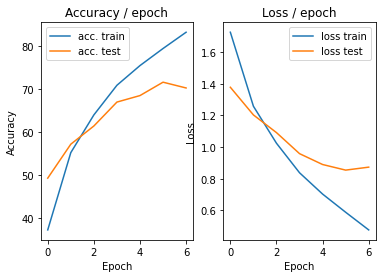

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.157s (0.157s)	Loss 0.3466 (0.3466)	Prec@1  88.3 ( 88.3)	Prec@5 100.0 (100.0)


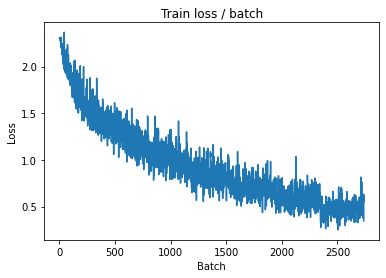

[TRAIN Batch 200/391]	Time 0.017s (0.031s)	Loss 0.2996 (0.3568)	Prec@1  89.8 ( 87.5)	Prec@5 100.0 ( 99.8)


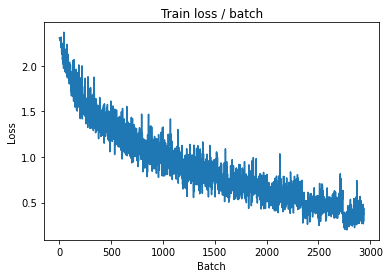


===============> Total time 12s	Avg loss 0.3700	Avg Prec@1 87.00 %	Avg Prec@5 99.74 %

[EVAL Batch 000/079]	Time 0.161s (0.161s)	Loss 0.8086 (0.8086)	Prec@1  76.6 ( 76.6)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.8823	Avg Prec@1 73.29 %	Avg Prec@5 97.78 %



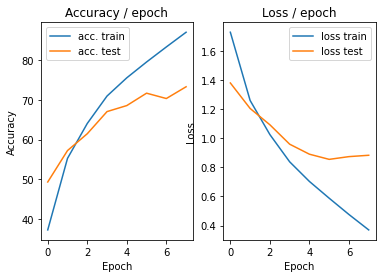

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.152s (0.152s)	Loss 0.3143 (0.3143)	Prec@1  89.1 ( 89.1)	Prec@5 100.0 (100.0)


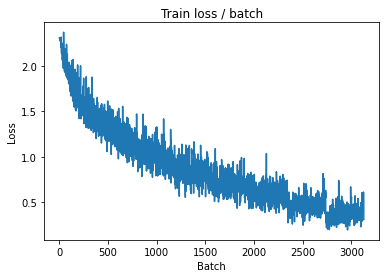

[TRAIN Batch 200/391]	Time 0.017s (0.030s)	Loss 0.2667 (0.2520)	Prec@1  89.1 ( 91.3)	Prec@5 100.0 ( 99.8)


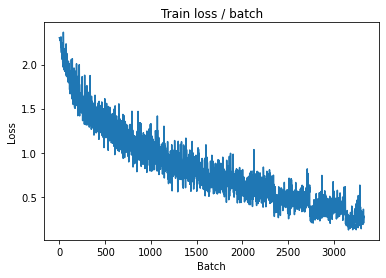


===============> Total time 11s	Avg loss 0.2758	Avg Prec@1 90.46 %	Avg Prec@5 99.85 %

[EVAL Batch 000/079]	Time 0.150s (0.150s)	Loss 0.9789 (0.9789)	Prec@1  77.3 ( 77.3)	Prec@5  96.1 ( 96.1)

===============> Total time 2s	Avg loss 0.9618	Avg Prec@1 72.63 %	Avg Prec@5 97.75 %



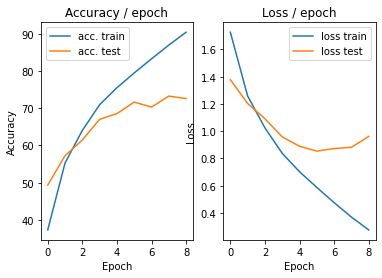

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.162s (0.162s)	Loss 0.1348 (0.1348)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


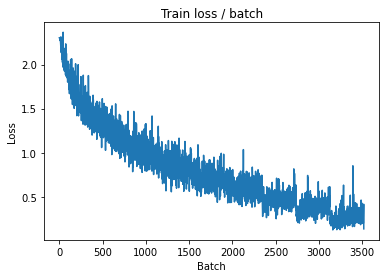

[TRAIN Batch 200/391]	Time 0.017s (0.031s)	Loss 0.2137 (0.1779)	Prec@1  89.8 ( 94.0)	Prec@5 100.0 ( 99.9)


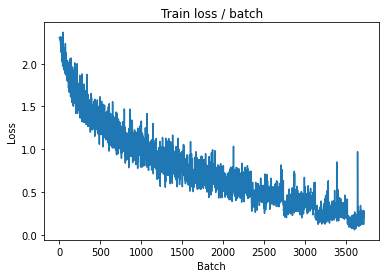


===============> Total time 11s	Avg loss 0.1969	Avg Prec@1 93.18 %	Avg Prec@5 99.93 %

[EVAL Batch 000/079]	Time 0.154s (0.154s)	Loss 0.9811 (0.9811)	Prec@1  68.8 ( 68.8)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 1.0061	Avg Prec@1 73.78 %	Avg Prec@5 97.99 %



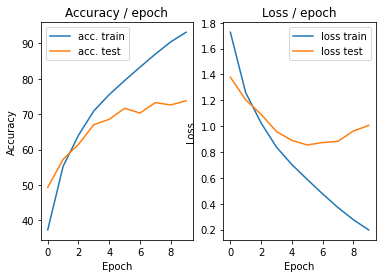

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.178s (0.178s)	Loss 0.1304 (0.1304)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


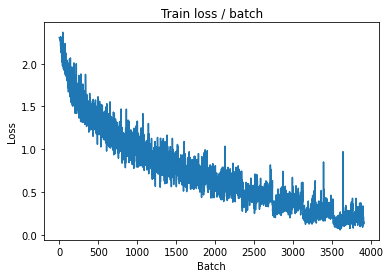

[TRAIN Batch 200/391]	Time 0.058s (0.031s)	Loss 0.1583 (0.1127)	Prec@1  94.5 ( 96.1)	Prec@5 100.0 (100.0)


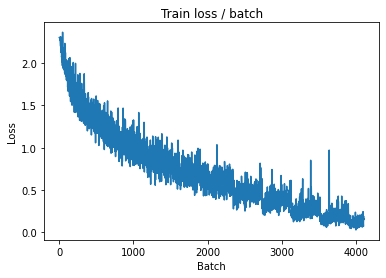


===============> Total time 11s	Avg loss 0.1405	Avg Prec@1 95.18 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.145s (0.145s)	Loss 0.9454 (0.9454)	Prec@1  71.9 ( 71.9)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 1.1907	Avg Prec@1 72.91 %	Avg Prec@5 97.65 %



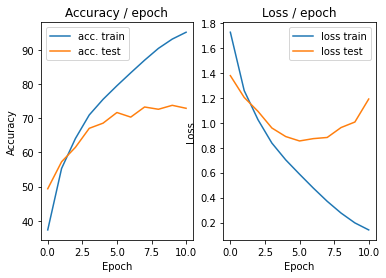

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.162s (0.162s)	Loss 0.1097 (0.1097)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


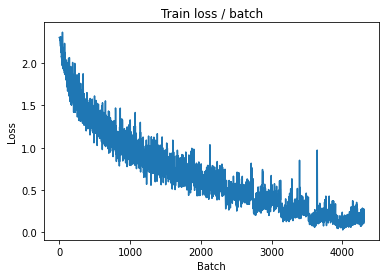

[TRAIN Batch 200/391]	Time 0.015s (0.030s)	Loss 0.0743 (0.0733)	Prec@1  97.7 ( 97.8)	Prec@5 100.0 (100.0)


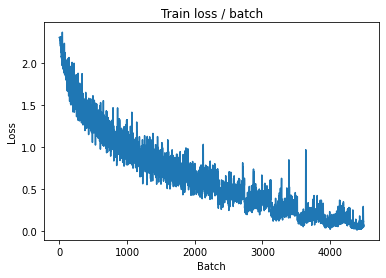


===============> Total time 11s	Avg loss 0.0990	Avg Prec@1 96.84 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.157s (0.157s)	Loss 1.3205 (1.3205)	Prec@1  70.3 ( 70.3)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 1.5174	Avg Prec@1 69.04 %	Avg Prec@5 97.42 %



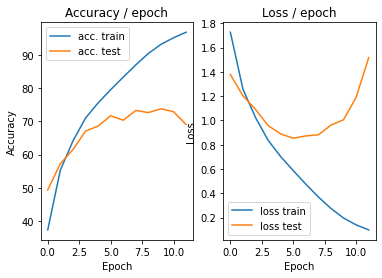

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.147s (0.147s)	Loss 0.2280 (0.2280)	Prec@1  92.2 ( 92.2)	Prec@5 100.0 (100.0)


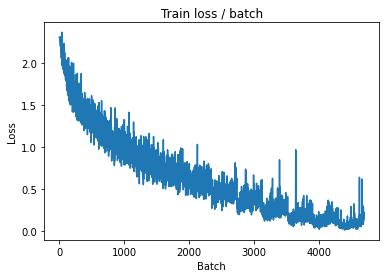

[TRAIN Batch 200/391]	Time 0.016s (0.031s)	Loss 0.0584 (0.0606)	Prec@1  99.2 ( 98.1)	Prec@5 100.0 (100.0)


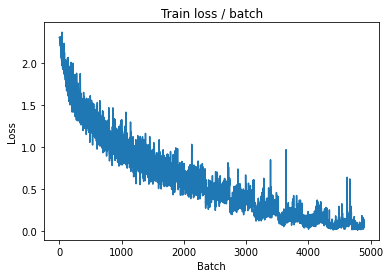


===============> Total time 11s	Avg loss 0.0795	Avg Prec@1 97.39 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.160s (0.160s)	Loss 1.0402 (1.0402)	Prec@1  76.6 ( 76.6)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 1.2206	Avg Prec@1 73.81 %	Avg Prec@5 97.90 %



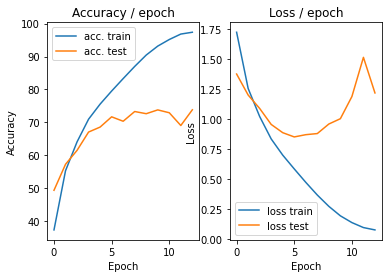

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.156s (0.156s)	Loss 0.0832 (0.0832)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


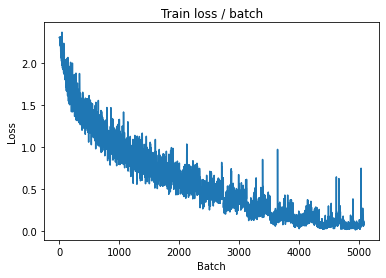

[TRAIN Batch 200/391]	Time 0.023s (0.031s)	Loss 0.2012 (0.0373)	Prec@1  93.8 ( 98.9)	Prec@5 100.0 (100.0)


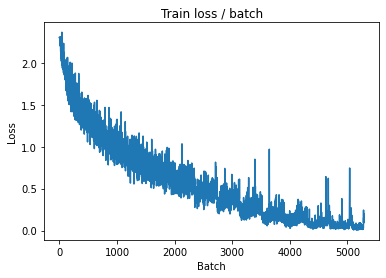


===============> Total time 11s	Avg loss 0.0540	Avg Prec@1 98.35 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.149s (0.149s)	Loss 1.0750 (1.0750)	Prec@1  76.6 ( 76.6)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 1.3592	Avg Prec@1 74.53 %	Avg Prec@5 97.76 %



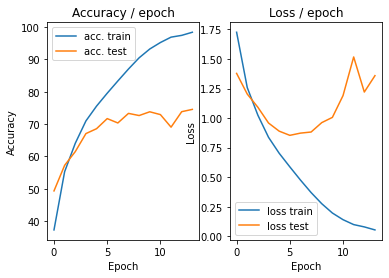

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.162s (0.162s)	Loss 0.0498 (0.0498)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


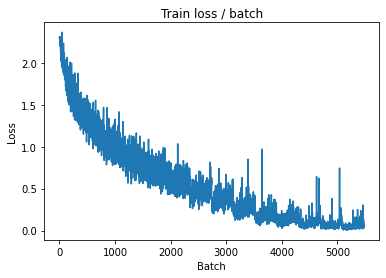

[TRAIN Batch 200/391]	Time 0.044s (0.030s)	Loss 0.0665 (0.0348)	Prec@1  96.9 ( 98.9)	Prec@5 100.0 (100.0)


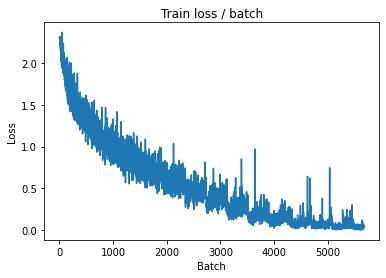


===============> Total time 11s	Avg loss 0.0522	Avg Prec@1 98.32 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.154s (0.154s)	Loss 1.7516 (1.7516)	Prec@1  67.2 ( 67.2)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 1.8364	Avg Prec@1 68.49 %	Avg Prec@5 96.11 %



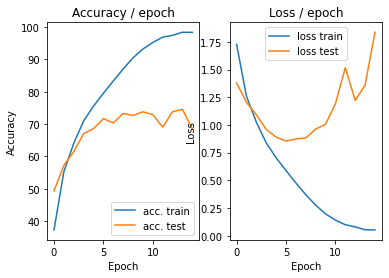

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.170s (0.170s)	Loss 0.2834 (0.2834)	Prec@1  85.9 ( 85.9)	Prec@5 100.0 (100.0)


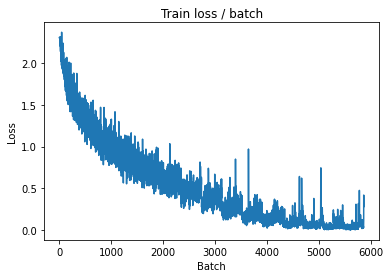

[TRAIN Batch 200/391]	Time 0.037s (0.030s)	Loss 0.0408 (0.0519)	Prec@1  98.4 ( 98.3)	Prec@5 100.0 (100.0)


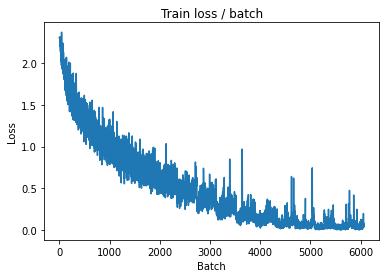


===============> Total time 11s	Avg loss 0.0560	Avg Prec@1 98.20 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.148s (0.148s)	Loss 1.1418 (1.1418)	Prec@1  76.6 ( 76.6)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 1.4158	Avg Prec@1 74.80 %	Avg Prec@5 97.74 %



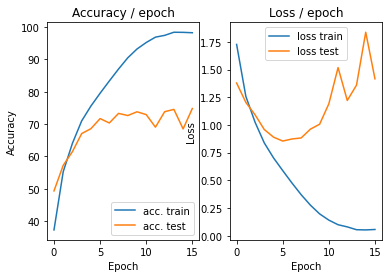

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.156s (0.156s)	Loss 0.0259 (0.0259)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


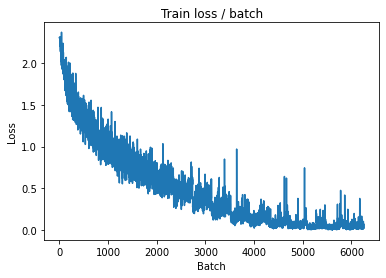

[TRAIN Batch 200/391]	Time 0.049s (0.030s)	Loss 0.0342 (0.0251)	Prec@1  99.2 ( 99.3)	Prec@5 100.0 (100.0)


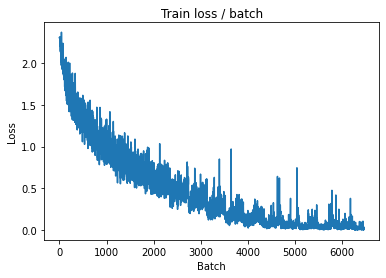


===============> Total time 11s	Avg loss 0.0439	Avg Prec@1 98.67 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.165s (0.165s)	Loss 1.7547 (1.7547)	Prec@1  73.4 ( 73.4)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 1.6461	Avg Prec@1 72.45 %	Avg Prec@5 97.20 %



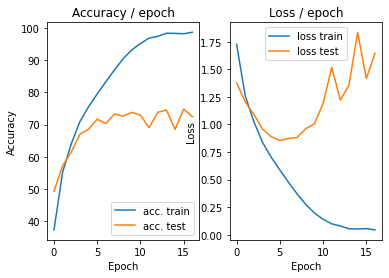

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.165s (0.165s)	Loss 0.0591 (0.0591)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


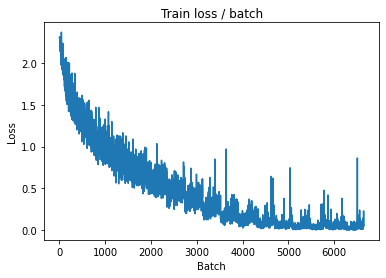

[TRAIN Batch 200/391]	Time 0.019s (0.031s)	Loss 0.0122 (0.0412)	Prec@1 100.0 ( 98.7)	Prec@5 100.0 (100.0)


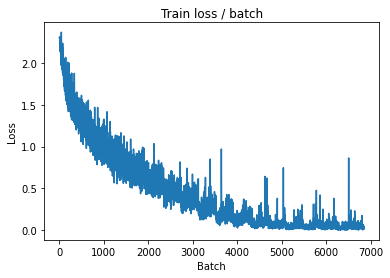


===============> Total time 12s	Avg loss 0.0482	Avg Prec@1 98.41 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.176s (0.176s)	Loss 1.3734 (1.3734)	Prec@1  77.3 ( 77.3)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 1.6081	Avg Prec@1 73.78 %	Avg Prec@5 97.65 %



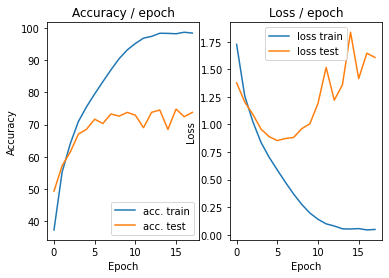

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.154s (0.154s)	Loss 0.0184 (0.0184)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


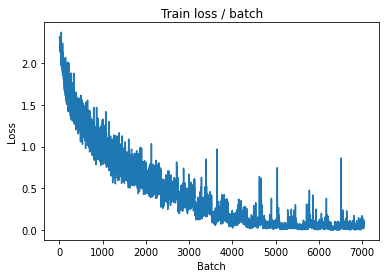

[TRAIN Batch 200/391]	Time 0.018s (0.033s)	Loss 0.0220 (0.0432)	Prec@1  98.4 ( 98.6)	Prec@5 100.0 (100.0)


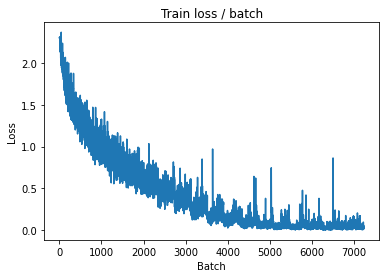


===============> Total time 12s	Avg loss 0.0469	Avg Prec@1 98.40 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.159s (0.159s)	Loss 1.8253 (1.8253)	Prec@1  72.7 ( 72.7)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 1.7951	Avg Prec@1 72.32 %	Avg Prec@5 97.10 %



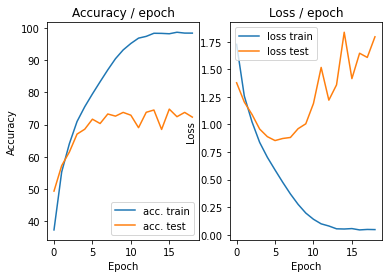

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.160s (0.160s)	Loss 0.0789 (0.0789)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


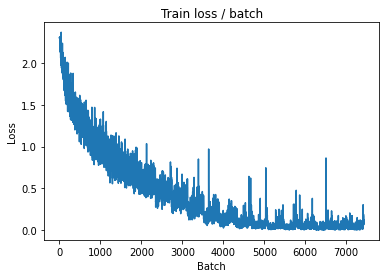

[TRAIN Batch 200/391]	Time 0.041s (0.030s)	Loss 0.0545 (0.0434)	Prec@1  97.7 ( 98.7)	Prec@5 100.0 (100.0)


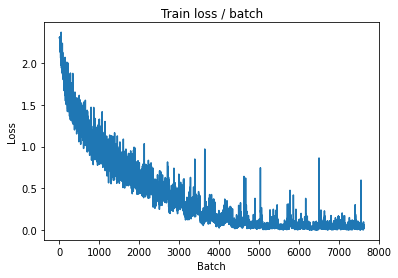


===============> Total time 11s	Avg loss 0.0441	Avg Prec@1 98.63 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.148s (0.148s)	Loss 1.7621 (1.7621)	Prec@1  70.3 ( 70.3)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 1.6228	Avg Prec@1 73.35 %	Avg Prec@5 97.32 %



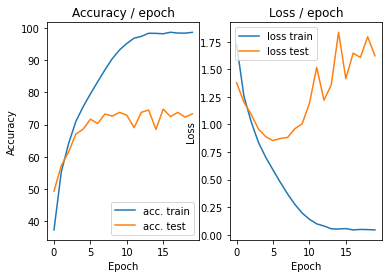

In [25]:
main3(128, 0.1, epochs=20 ,cuda=True)

### 3.2 Augmentation du nombre d’exemples d’apprentissage par data augmentation

In [26]:
class ConvNet4(nn.Module):
    """
    Cette classe contient la structure du réseau de neurones
    """

    def __init__(self):
        super(ConvNet4, self).__init__()
        # On défini d'abord les couches de convolution et de pooling comme un
        # groupe de couches `self.features`
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),
        )
        # On défini les couches fully connected comme un groupe de couches
        # `self.classifier`
        self.classifier = nn.Sequential(
            nn.Linear(4*4*64, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Rappel : Le softmax est inclus dans la loss, ne pas le mettre ici
        )

    # méthode appelée quand on applique le réseau à un batch d'input
    def forward(self, input):
        bsize = input.size(0) # taille du batch
        output = self.features(input) # on calcule la sortie des conv

        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input

        output = self.classifier(output) # on calcule la sortie des fc
        return output



def get_dataset(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et effectue des transformations sur chaqu
    image (listées dans `transform=...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201]),
            transforms.RandomCrop(28),
            transforms.RandomHorizontalFlip(),
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201]),
            transforms.CenterCrop(28),
 
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # si on fait du GPU, passage en CUDA
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss

def main4(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex de params :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet4()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # On récupère les données
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Phase d'evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.289s (0.289s)	Loss 2.3052 (2.3052)	Prec@1   5.5 (  5.5)	Prec@5  49.2 ( 49.2)


<Figure size 432x288 with 0 Axes>

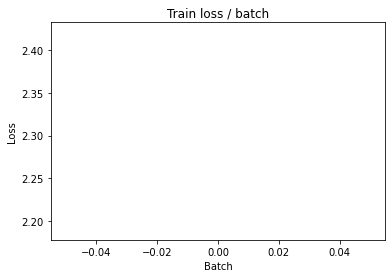

[TRAIN Batch 200/391]	Time 0.052s (0.043s)	Loss 1.6905 (1.9503)	Prec@1  43.8 ( 28.0)	Prec@5  87.5 ( 79.2)


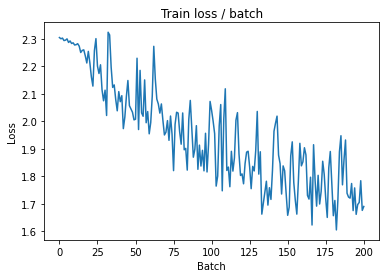


===============> Total time 16s	Avg loss 1.7919	Avg Prec@1 34.16 %	Avg Prec@5 84.30 %

[EVAL Batch 000/079]	Time 0.168s (0.168s)	Loss 1.6395 (1.6395)	Prec@1  44.5 ( 44.5)	Prec@5  89.1 ( 89.1)

===============> Total time 2s	Avg loss 1.6488	Avg Prec@1 41.76 %	Avg Prec@5 88.80 %



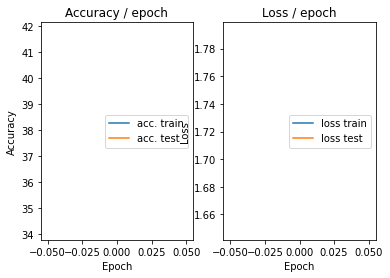

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.188s (0.188s)	Loss 1.7101 (1.7101)	Prec@1  38.3 ( 38.3)	Prec@5  88.3 ( 88.3)


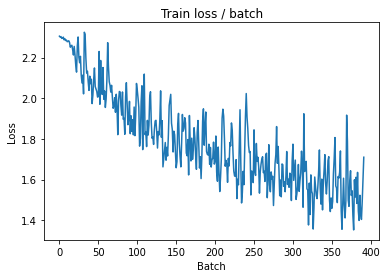

[TRAIN Batch 200/391]	Time 0.038s (0.045s)	Loss 1.5268 (1.4584)	Prec@1  50.0 ( 47.8)	Prec@5  91.4 ( 92.3)


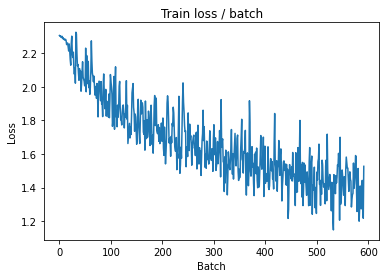


===============> Total time 17s	Avg loss 1.4056	Avg Prec@1 49.61 %	Avg Prec@5 93.01 %

[EVAL Batch 000/079]	Time 0.160s (0.160s)	Loss 1.2115 (1.2115)	Prec@1  60.9 ( 60.9)	Prec@5  93.8 ( 93.8)

===============> Total time 2s	Avg loss 1.2586	Avg Prec@1 54.48 %	Avg Prec@5 94.77 %



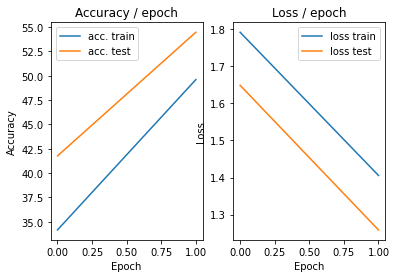

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.201s (0.201s)	Loss 1.3575 (1.3575)	Prec@1  52.3 ( 52.3)	Prec@5  95.3 ( 95.3)


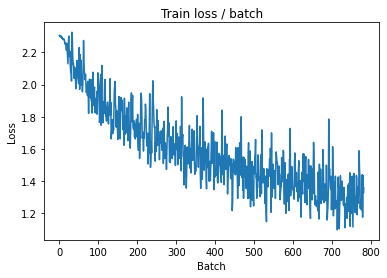

[TRAIN Batch 200/391]	Time 0.016s (0.045s)	Loss 1.3573 (1.2444)	Prec@1  50.8 ( 56.0)	Prec@5  95.3 ( 94.7)


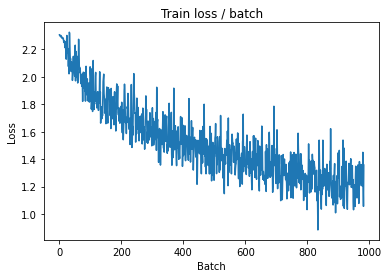


===============> Total time 17s	Avg loss 1.2096	Avg Prec@1 57.39 %	Avg Prec@5 95.03 %

[EVAL Batch 000/079]	Time 0.167s (0.167s)	Loss 1.0187 (1.0187)	Prec@1  68.0 ( 68.0)	Prec@5  95.3 ( 95.3)

===============> Total time 2s	Avg loss 1.0470	Avg Prec@1 63.58 %	Avg Prec@5 96.46 %



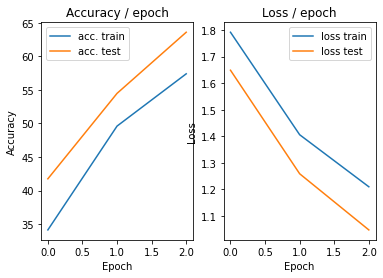

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.184s (0.184s)	Loss 1.0081 (1.0081)	Prec@1  62.5 ( 62.5)	Prec@5  99.2 ( 99.2)


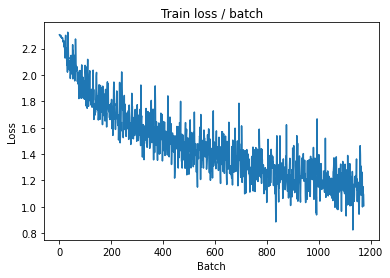

[TRAIN Batch 200/391]	Time 0.071s (0.044s)	Loss 0.9091 (1.0833)	Prec@1  65.6 ( 61.8)	Prec@5  96.9 ( 96.1)


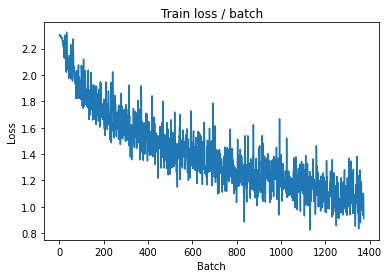


===============> Total time 16s	Avg loss 1.0554	Avg Prec@1 63.03 %	Avg Prec@5 96.29 %

[EVAL Batch 000/079]	Time 0.156s (0.156s)	Loss 0.9573 (0.9573)	Prec@1  69.5 ( 69.5)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 0.9748	Avg Prec@1 65.77 %	Avg Prec@5 96.97 %



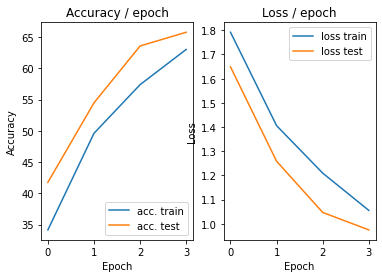

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.182s (0.182s)	Loss 0.8855 (0.8855)	Prec@1  69.5 ( 69.5)	Prec@5  97.7 ( 97.7)


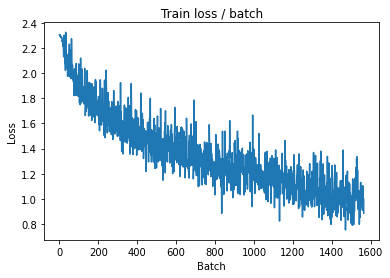

[TRAIN Batch 200/391]	Time 0.080s (0.044s)	Loss 0.9132 (0.9477)	Prec@1  67.2 ( 67.0)	Prec@5  99.2 ( 97.0)


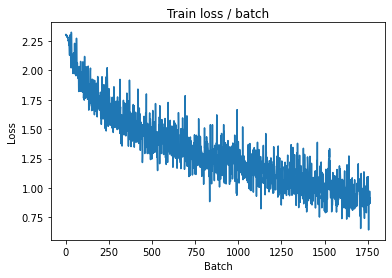


===============> Total time 16s	Avg loss 0.9367	Avg Prec@1 67.46 %	Avg Prec@5 97.12 %

[EVAL Batch 000/079]	Time 0.144s (0.144s)	Loss 0.9583 (0.9583)	Prec@1  71.9 ( 71.9)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 0.9630	Avg Prec@1 67.95 %	Avg Prec@5 96.60 %



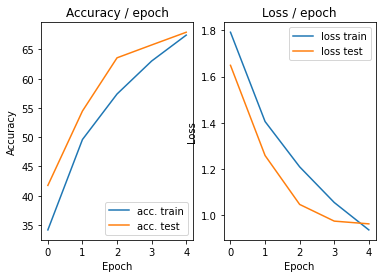

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.208s (0.208s)	Loss 0.6555 (0.6555)	Prec@1  78.9 ( 78.9)	Prec@5  99.2 ( 99.2)


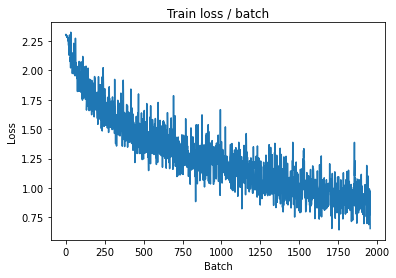

[TRAIN Batch 200/391]	Time 0.014s (0.045s)	Loss 1.0648 (0.8609)	Prec@1  62.5 ( 70.1)	Prec@5  96.9 ( 97.5)


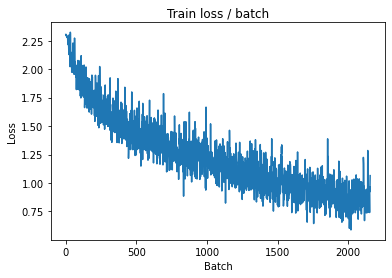


===============> Total time 17s	Avg loss 0.8556	Avg Prec@1 70.13 %	Avg Prec@5 97.53 %

[EVAL Batch 000/079]	Time 0.177s (0.177s)	Loss 0.8204 (0.8204)	Prec@1  74.2 ( 74.2)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 0.8067	Avg Prec@1 72.19 %	Avg Prec@5 97.81 %



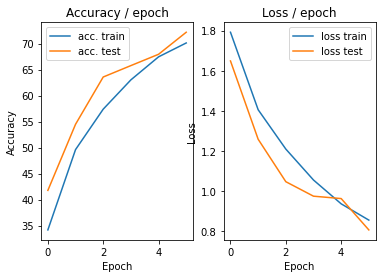

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.187s (0.187s)	Loss 0.6465 (0.6465)	Prec@1  78.9 ( 78.9)	Prec@5  98.4 ( 98.4)


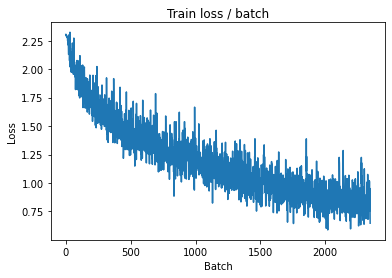

[TRAIN Batch 200/391]	Time 0.072s (0.044s)	Loss 0.8140 (0.7881)	Prec@1  68.8 ( 72.8)	Prec@5  98.4 ( 98.0)


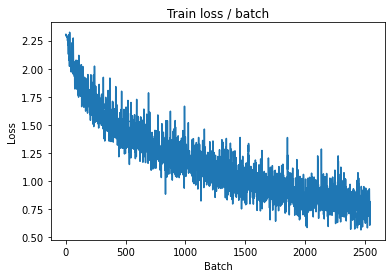


===============> Total time 17s	Avg loss 0.7829	Avg Prec@1 72.89 %	Avg Prec@5 98.01 %

[EVAL Batch 000/079]	Time 0.168s (0.168s)	Loss 0.7211 (0.7211)	Prec@1  73.4 ( 73.4)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.7771	Avg Prec@1 73.28 %	Avg Prec@5 97.97 %



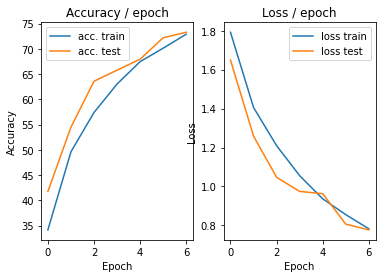

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.187s (0.187s)	Loss 0.6911 (0.6911)	Prec@1  78.9 ( 78.9)	Prec@5  98.4 ( 98.4)


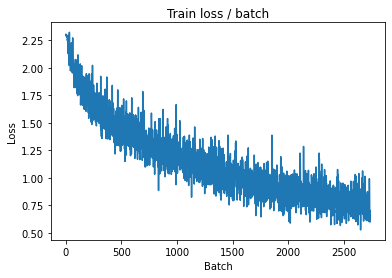

[TRAIN Batch 200/391]	Time 0.014s (0.046s)	Loss 0.7371 (0.7337)	Prec@1  70.3 ( 74.6)	Prec@5 100.0 ( 98.4)


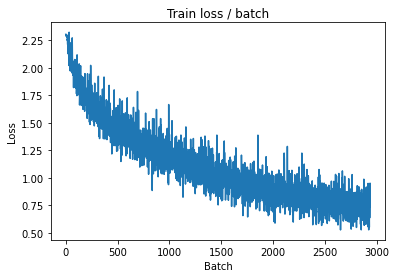


===============> Total time 17s	Avg loss 0.7238	Avg Prec@1 74.80 %	Avg Prec@5 98.38 %

[EVAL Batch 000/079]	Time 0.146s (0.146s)	Loss 0.8341 (0.8341)	Prec@1  77.3 ( 77.3)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.8627	Avg Prec@1 69.68 %	Avg Prec@5 97.99 %



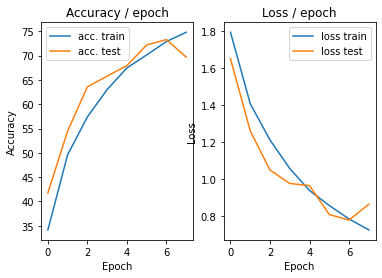

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.181s (0.181s)	Loss 0.7151 (0.7151)	Prec@1  74.2 ( 74.2)	Prec@5  99.2 ( 99.2)


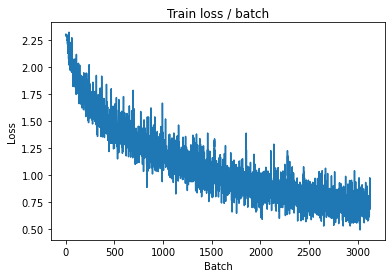

[TRAIN Batch 200/391]	Time 0.023s (0.044s)	Loss 0.7023 (0.6853)	Prec@1  74.2 ( 76.3)	Prec@5 100.0 ( 98.6)


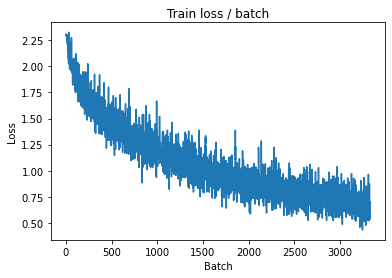


===============> Total time 17s	Avg loss 0.6805	Avg Prec@1 76.44 %	Avg Prec@5 98.55 %

[EVAL Batch 000/079]	Time 0.156s (0.156s)	Loss 0.7520 (0.7520)	Prec@1  71.1 ( 71.1)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.7890	Avg Prec@1 73.19 %	Avg Prec@5 98.06 %



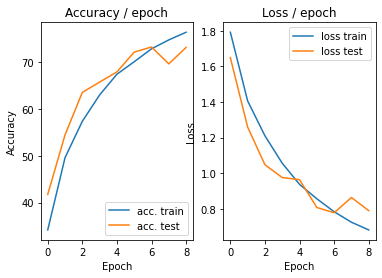

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.193s (0.193s)	Loss 0.8243 (0.8243)	Prec@1  79.7 ( 79.7)	Prec@5  97.7 ( 97.7)


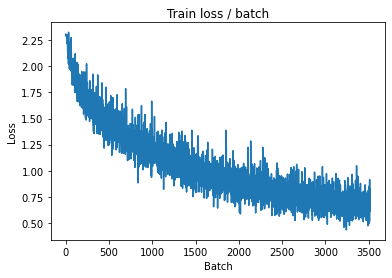

[TRAIN Batch 200/391]	Time 0.015s (0.044s)	Loss 0.6917 (0.6353)	Prec@1  78.9 ( 77.9)	Prec@5  96.1 ( 98.7)


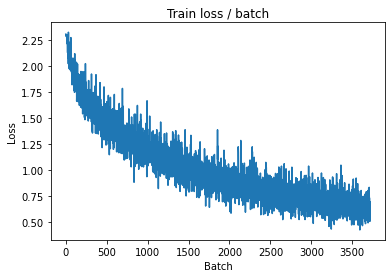


===============> Total time 17s	Avg loss 0.6354	Avg Prec@1 77.98 %	Avg Prec@5 98.68 %

[EVAL Batch 000/079]	Time 0.153s (0.153s)	Loss 0.7103 (0.7103)	Prec@1  76.6 ( 76.6)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.7286	Avg Prec@1 75.35 %	Avg Prec@5 98.25 %



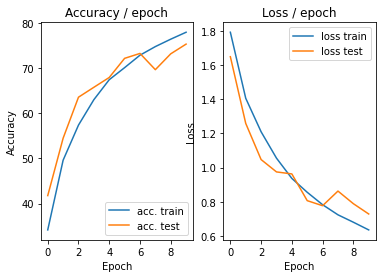

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.185s (0.185s)	Loss 0.7253 (0.7253)	Prec@1  74.2 ( 74.2)	Prec@5  98.4 ( 98.4)


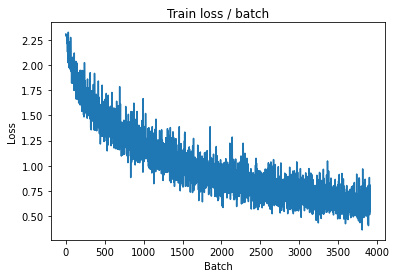

[TRAIN Batch 200/391]	Time 0.016s (0.044s)	Loss 0.5234 (0.6000)	Prec@1  78.1 ( 79.0)	Prec@5 100.0 ( 98.9)


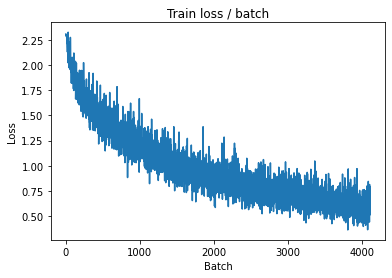


===============> Total time 17s	Avg loss 0.6011	Avg Prec@1 78.91 %	Avg Prec@5 98.92 %

[EVAL Batch 000/079]	Time 0.164s (0.164s)	Loss 0.6861 (0.6861)	Prec@1  79.7 ( 79.7)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.6719	Avg Prec@1 77.22 %	Avg Prec@5 98.56 %



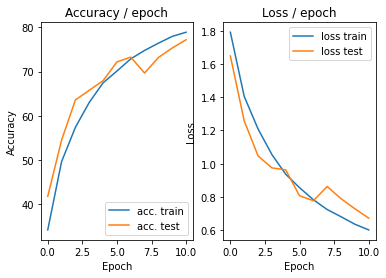

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.196s (0.196s)	Loss 0.5956 (0.5956)	Prec@1  78.9 ( 78.9)	Prec@5 100.0 (100.0)


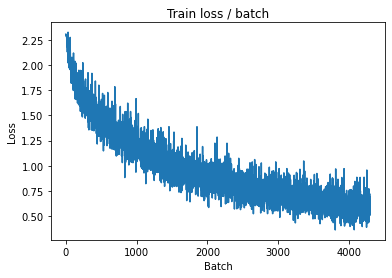

[TRAIN Batch 200/391]	Time 0.018s (0.044s)	Loss 0.7970 (0.5719)	Prec@1  71.1 ( 80.0)	Prec@5  96.9 ( 99.1)


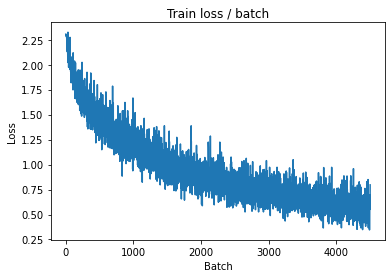


===============> Total time 17s	Avg loss 0.5717	Avg Prec@1 80.06 %	Avg Prec@5 99.02 %

[EVAL Batch 000/079]	Time 0.180s (0.180s)	Loss 0.6440 (0.6440)	Prec@1  78.9 ( 78.9)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.6550	Avg Prec@1 78.08 %	Avg Prec@5 98.53 %



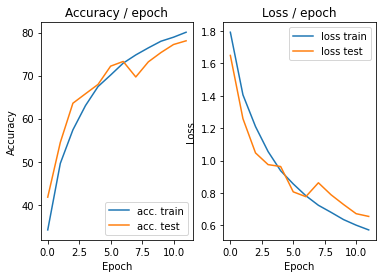

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.184s (0.184s)	Loss 0.5307 (0.5307)	Prec@1  83.6 ( 83.6)	Prec@5  97.7 ( 97.7)


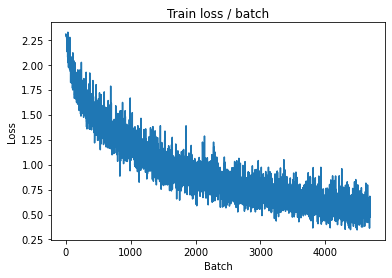

[TRAIN Batch 200/391]	Time 0.073s (0.043s)	Loss 0.4850 (0.5327)	Prec@1  85.2 ( 81.2)	Prec@5  98.4 ( 99.2)


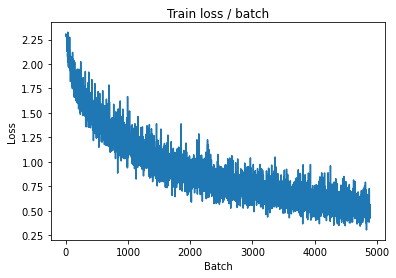


===============> Total time 17s	Avg loss 0.5413	Avg Prec@1 81.14 %	Avg Prec@5 99.15 %

[EVAL Batch 000/079]	Time 0.160s (0.160s)	Loss 0.8446 (0.8446)	Prec@1  74.2 ( 74.2)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.7614	Avg Prec@1 75.16 %	Avg Prec@5 98.12 %



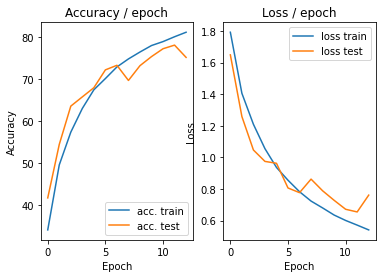

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.183s (0.183s)	Loss 0.5211 (0.5211)	Prec@1  82.0 ( 82.0)	Prec@5  99.2 ( 99.2)


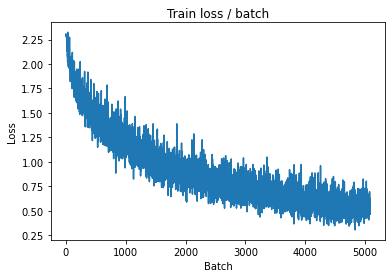

[TRAIN Batch 200/391]	Time 0.056s (0.046s)	Loss 0.5269 (0.5072)	Prec@1  82.0 ( 82.5)	Prec@5  99.2 ( 99.3)


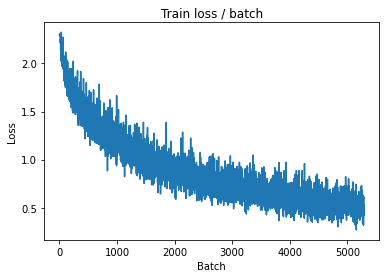


===============> Total time 17s	Avg loss 0.5139	Avg Prec@1 82.22 %	Avg Prec@5 99.28 %

[EVAL Batch 000/079]	Time 0.171s (0.171s)	Loss 0.7205 (0.7205)	Prec@1  76.6 ( 76.6)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 0.6741	Avg Prec@1 77.71 %	Avg Prec@5 98.59 %



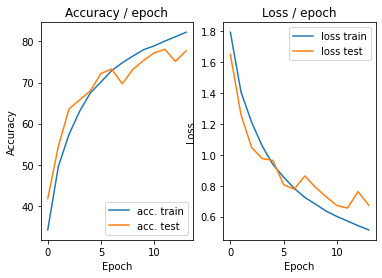

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.207s (0.207s)	Loss 0.6887 (0.6887)	Prec@1  80.5 ( 80.5)	Prec@5  96.9 ( 96.9)


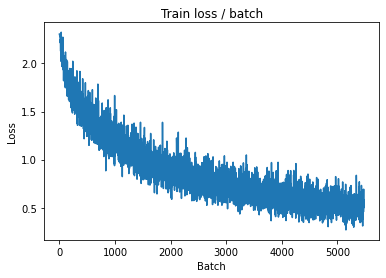

[TRAIN Batch 200/391]	Time 0.073s (0.047s)	Loss 0.4327 (0.4858)	Prec@1  84.4 ( 83.0)	Prec@5 100.0 ( 99.3)


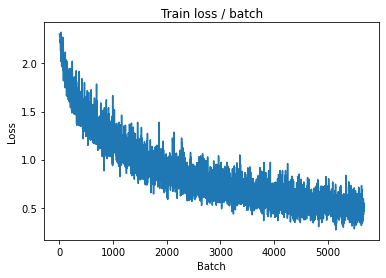


===============> Total time 17s	Avg loss 0.4882	Avg Prec@1 82.93 %	Avg Prec@5 99.31 %

[EVAL Batch 000/079]	Time 0.170s (0.170s)	Loss 0.6595 (0.6595)	Prec@1  78.9 ( 78.9)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.6650	Avg Prec@1 77.89 %	Avg Prec@5 98.73 %



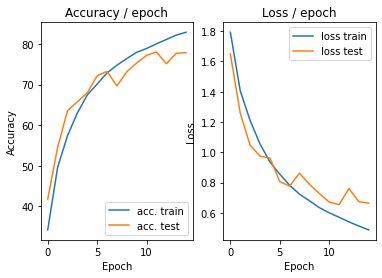

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.185s (0.185s)	Loss 0.5177 (0.5177)	Prec@1  82.8 ( 82.8)	Prec@5  99.2 ( 99.2)


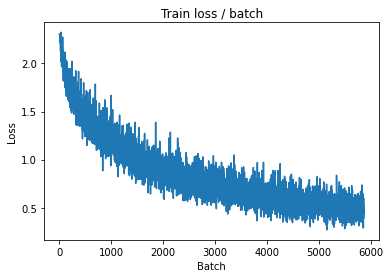

[TRAIN Batch 200/391]	Time 0.070s (0.045s)	Loss 0.4844 (0.4601)	Prec@1  81.2 ( 83.9)	Prec@5 100.0 ( 99.4)


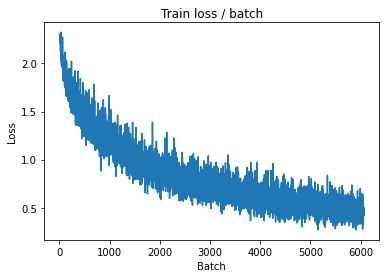


===============> Total time 17s	Avg loss 0.4706	Avg Prec@1 83.45 %	Avg Prec@5 99.38 %

[EVAL Batch 000/079]	Time 0.160s (0.160s)	Loss 0.7462 (0.7462)	Prec@1  75.0 ( 75.0)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.7515	Avg Prec@1 76.33 %	Avg Prec@5 98.46 %



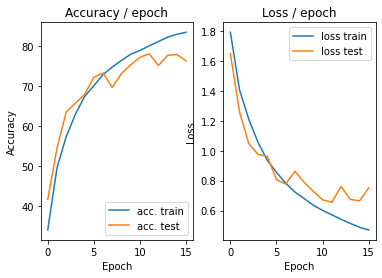

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.189s (0.189s)	Loss 0.5609 (0.5609)	Prec@1  78.9 ( 78.9)	Prec@5  97.7 ( 97.7)


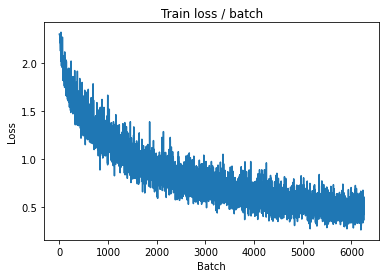

[TRAIN Batch 200/391]	Time 0.078s (0.047s)	Loss 0.4322 (0.4405)	Prec@1  84.4 ( 84.6)	Prec@5 100.0 ( 99.5)


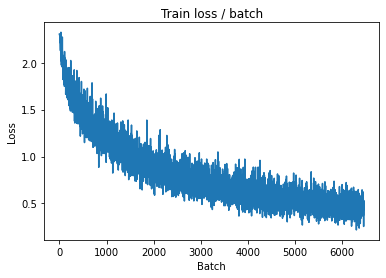


===============> Total time 18s	Avg loss 0.4452	Avg Prec@1 84.44 %	Avg Prec@5 99.48 %

[EVAL Batch 000/079]	Time 0.158s (0.158s)	Loss 0.5841 (0.5841)	Prec@1  81.2 ( 81.2)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.6191	Avg Prec@1 79.53 %	Avg Prec@5 98.82 %



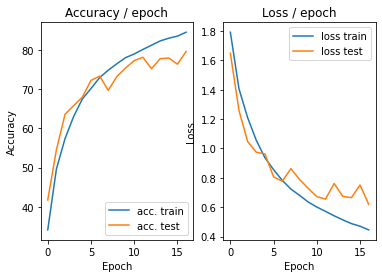

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.190s (0.190s)	Loss 0.3317 (0.3317)	Prec@1  89.1 ( 89.1)	Prec@5  99.2 ( 99.2)


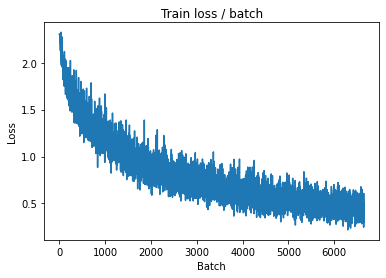

[TRAIN Batch 200/391]	Time 0.080s (0.046s)	Loss 0.4043 (0.4197)	Prec@1  86.7 ( 85.4)	Prec@5 100.0 ( 99.5)


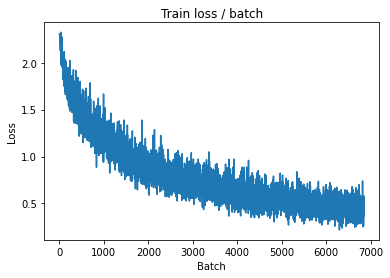


===============> Total time 17s	Avg loss 0.4214	Avg Prec@1 85.20 %	Avg Prec@5 99.52 %

[EVAL Batch 000/079]	Time 0.167s (0.167s)	Loss 0.7093 (0.7093)	Prec@1  77.3 ( 77.3)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.6437	Avg Prec@1 79.18 %	Avg Prec@5 98.53 %



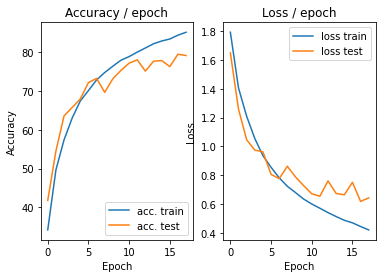

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.185s (0.185s)	Loss 0.3935 (0.3935)	Prec@1  89.1 ( 89.1)	Prec@5 100.0 (100.0)


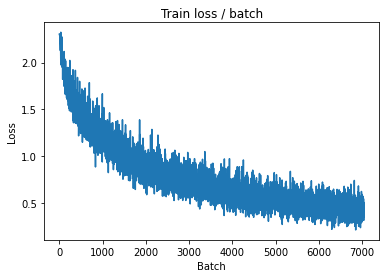

[TRAIN Batch 200/391]	Time 0.014s (0.045s)	Loss 0.3143 (0.3902)	Prec@1  89.8 ( 86.4)	Prec@5 100.0 ( 99.6)


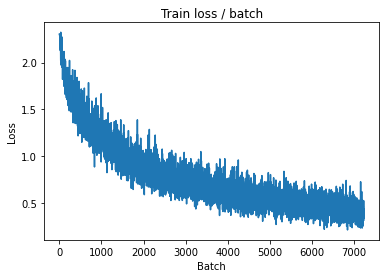


===============> Total time 17s	Avg loss 0.4050	Avg Prec@1 85.88 %	Avg Prec@5 99.61 %

[EVAL Batch 000/079]	Time 0.177s (0.177s)	Loss 0.6825 (0.6825)	Prec@1  78.9 ( 78.9)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.6555	Avg Prec@1 79.08 %	Avg Prec@5 98.64 %



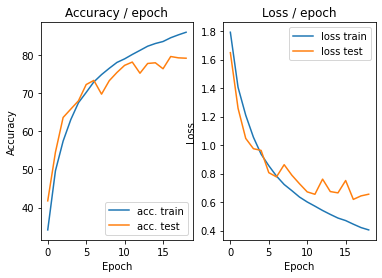

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.191s (0.191s)	Loss 0.4370 (0.4370)	Prec@1  85.9 ( 85.9)	Prec@5 100.0 (100.0)


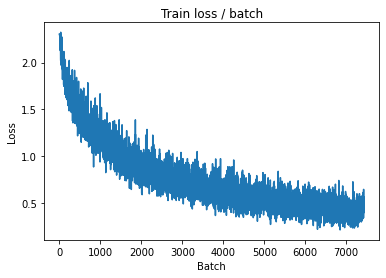

[TRAIN Batch 200/391]	Time 0.060s (0.047s)	Loss 0.3413 (0.3852)	Prec@1  89.1 ( 86.5)	Prec@5 100.0 ( 99.7)


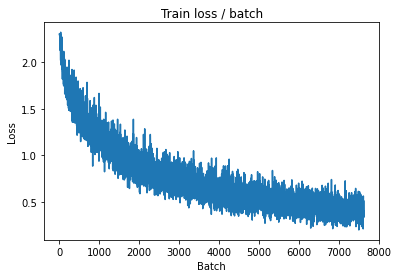


===============> Total time 17s	Avg loss 0.3905	Avg Prec@1 86.30 %	Avg Prec@5 99.62 %

[EVAL Batch 000/079]	Time 0.151s (0.151s)	Loss 0.8336 (0.8336)	Prec@1  75.0 ( 75.0)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.6418	Avg Prec@1 79.93 %	Avg Prec@5 98.86 %



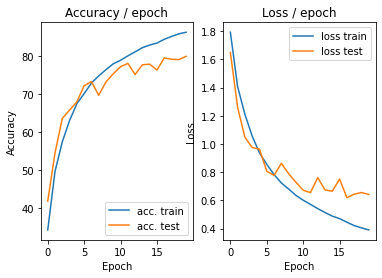

In [27]:
main4(128, 0.1, epochs=20 ,cuda=True)

### 3.3 Variantes sur l’algorithme d’optimisation
#### d'abord avec un momentum seul sans schedular

In [43]:
class ConvNet5(nn.Module):
    """
    Cette classe contient la structure du réseau de neurones
    """

    def __init__(self):
        super(ConvNet5, self).__init__()
        # On défini d'abord les couches de convolution et de pooling comme un
        # groupe de couches `self.features`
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),
        )
        # On défini les couches fully connected comme un groupe de couches
        # `self.classifier`
        self.classifier = nn.Sequential(
            nn.Linear(4*4*64, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Rappel : Le softmax est inclus dans la loss, ne pas le mettre ici
        )

    # méthode appelée quand on applique le réseau à un batch d'input
    def forward(self, input):
        bsize = input.size(0) # taille du batch
        output = self.features(input) # on calcule la sortie des conv

        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input

        output = self.classifier(output) # on calcule la sortie des fc
        return output



def get_dataset(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et effectue des transformations sur chaqu
    image (listées dans `transform=...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201]),
            transforms.RandomCrop(28),
            transforms.RandomHorizontalFlip(),
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201]),
            transforms.CenterCrop(28),
 
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # si on fait du GPU, passage en CUDA
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss

def main5(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex de params :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet5()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
    # lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


    if cuda: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # On récupère les données
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Phase d'evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.183s (0.183s)	Loss 2.3032 (2.3032)	Prec@1   7.8 (  7.8)	Prec@5  53.1 ( 53.1)


<Figure size 432x288 with 0 Axes>

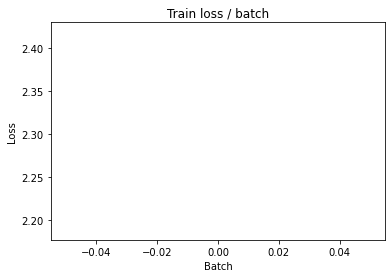

[TRAIN Batch 200/391]	Time 0.016s (0.044s)	Loss 2.0170 (1.9867)	Prec@1  26.6 ( 26.5)	Prec@5  74.2 ( 79.5)


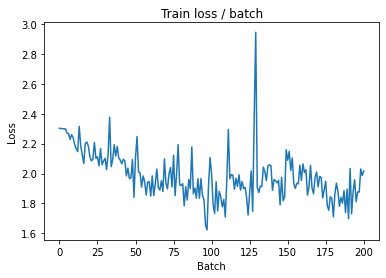


===============> Total time 17s	Avg loss 1.8704	Avg Prec@1 30.87 %	Avg Prec@5 83.37 %

[EVAL Batch 000/079]	Time 0.145s (0.145s)	Loss 1.6734 (1.6734)	Prec@1  33.6 ( 33.6)	Prec@5  89.8 ( 89.8)

===============> Total time 2s	Avg loss 1.6573	Avg Prec@1 40.22 %	Avg Prec@5 89.41 %



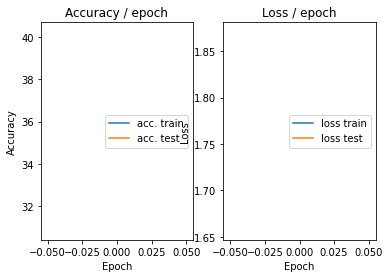

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.179s (0.179s)	Loss 1.7478 (1.7478)	Prec@1  40.6 ( 40.6)	Prec@5  86.7 ( 86.7)


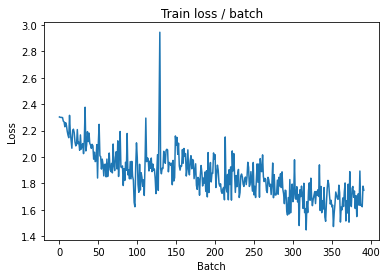

[TRAIN Batch 200/391]	Time 0.014s (0.044s)	Loss 1.7355 (1.6414)	Prec@1  33.6 ( 39.7)	Prec@5  85.9 ( 88.9)


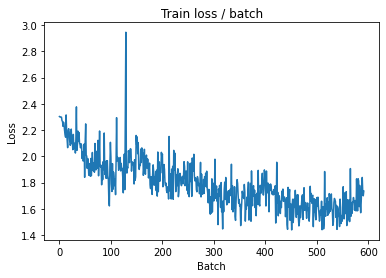


===============> Total time 17s	Avg loss 1.6232	Avg Prec@1 40.92 %	Avg Prec@5 89.39 %

[EVAL Batch 000/079]	Time 0.160s (0.160s)	Loss 1.4635 (1.4635)	Prec@1  45.3 ( 45.3)	Prec@5  92.2 ( 92.2)

===============> Total time 2s	Avg loss 1.5101	Avg Prec@1 45.82 %	Avg Prec@5 90.82 %



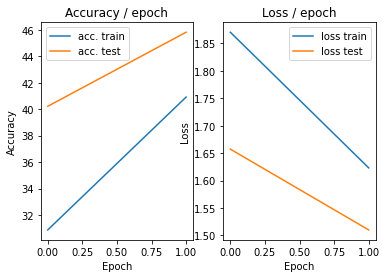

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.192s (0.192s)	Loss 1.7507 (1.7507)	Prec@1  45.3 ( 45.3)	Prec@5  89.1 ( 89.1)


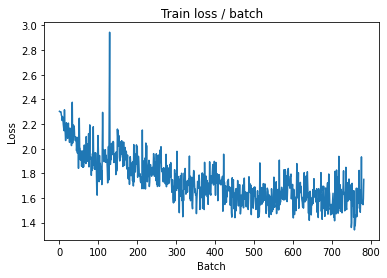

[TRAIN Batch 200/391]	Time 0.072s (0.045s)	Loss 1.5559 (1.5695)	Prec@1  39.1 ( 43.7)	Prec@5  88.3 ( 90.7)


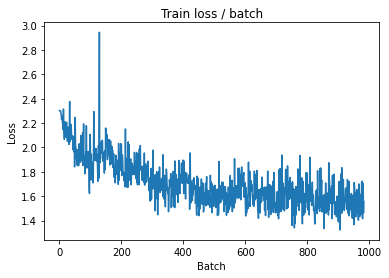


===============> Total time 17s	Avg loss 1.5623	Avg Prec@1 43.94 %	Avg Prec@5 90.51 %

[EVAL Batch 000/079]	Time 0.160s (0.160s)	Loss 1.4769 (1.4769)	Prec@1  50.8 ( 50.8)	Prec@5  92.2 ( 92.2)

===============> Total time 2s	Avg loss 1.4717	Avg Prec@1 47.07 %	Avg Prec@5 91.75 %



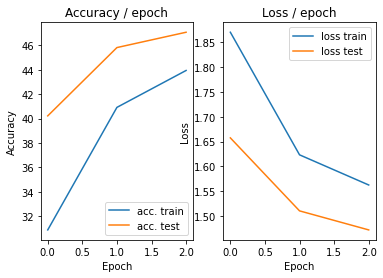

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.185s (0.185s)	Loss 1.5493 (1.5493)	Prec@1  37.5 ( 37.5)	Prec@5  92.2 ( 92.2)


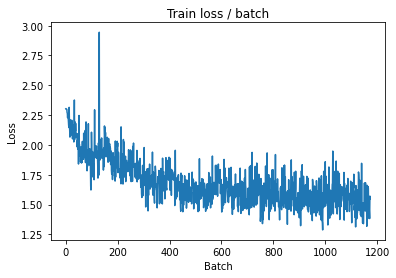

[TRAIN Batch 200/391]	Time 0.045s (0.045s)	Loss 1.6011 (1.5302)	Prec@1  39.1 ( 44.6)	Prec@5  93.0 ( 91.2)


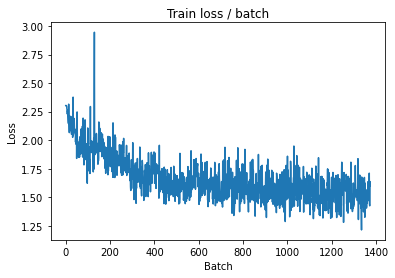


===============> Total time 17s	Avg loss 1.5402	Avg Prec@1 44.72 %	Avg Prec@5 90.84 %

[EVAL Batch 000/079]	Time 0.165s (0.165s)	Loss 1.5869 (1.5869)	Prec@1  42.2 ( 42.2)	Prec@5  93.0 ( 93.0)

===============> Total time 2s	Avg loss 1.5682	Avg Prec@1 43.57 %	Avg Prec@5 90.77 %



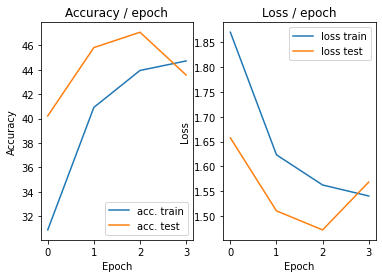

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.212s (0.212s)	Loss 1.5698 (1.5698)	Prec@1  41.4 ( 41.4)	Prec@5  95.3 ( 95.3)


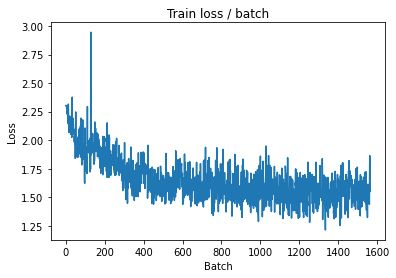

[TRAIN Batch 200/391]	Time 0.076s (0.045s)	Loss 1.5131 (1.5196)	Prec@1  46.1 ( 45.9)	Prec@5  93.8 ( 90.9)


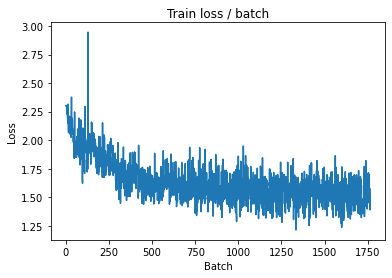


===============> Total time 17s	Avg loss 1.5264	Avg Prec@1 45.74 %	Avg Prec@5 90.96 %

[EVAL Batch 000/079]	Time 0.179s (0.179s)	Loss 1.5027 (1.5027)	Prec@1  45.3 ( 45.3)	Prec@5  87.5 ( 87.5)

===============> Total time 2s	Avg loss 1.4957	Avg Prec@1 48.07 %	Avg Prec@5 91.00 %



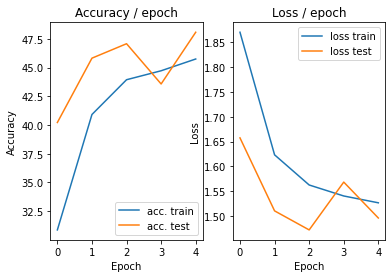

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.197s (0.197s)	Loss 1.4672 (1.4672)	Prec@1  46.1 ( 46.1)	Prec@5  92.2 ( 92.2)


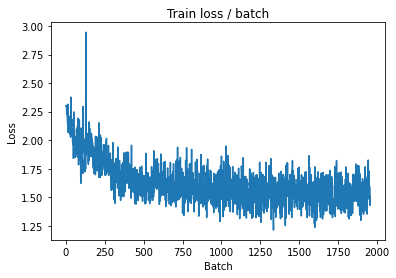

[TRAIN Batch 200/391]	Time 0.062s (0.045s)	Loss 1.4895 (1.5323)	Prec@1  50.0 ( 45.8)	Prec@5  88.3 ( 90.7)


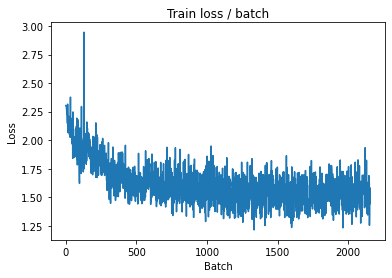


===============> Total time 17s	Avg loss 1.5330	Avg Prec@1 45.88 %	Avg Prec@5 90.67 %

[EVAL Batch 000/079]	Time 0.163s (0.163s)	Loss 1.5306 (1.5306)	Prec@1  47.7 ( 47.7)	Prec@5  90.6 ( 90.6)

===============> Total time 2s	Avg loss 1.5259	Avg Prec@1 47.75 %	Avg Prec@5 91.95 %



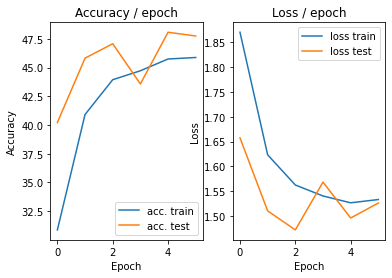

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.190s (0.190s)	Loss 1.3434 (1.3434)	Prec@1  53.1 ( 53.1)	Prec@5  93.8 ( 93.8)


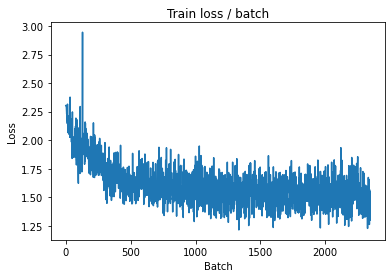

[TRAIN Batch 200/391]	Time 0.017s (0.045s)	Loss 1.4651 (1.5269)	Prec@1  46.1 ( 46.3)	Prec@5  88.3 ( 90.8)


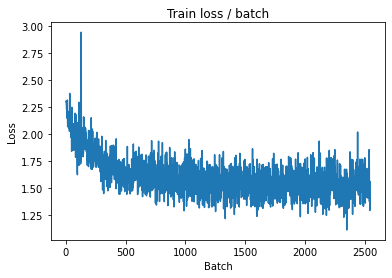


===============> Total time 17s	Avg loss 1.5222	Avg Prec@1 46.69 %	Avg Prec@5 90.80 %

[EVAL Batch 000/079]	Time 0.172s (0.172s)	Loss 1.6591 (1.6591)	Prec@1  46.9 ( 46.9)	Prec@5  87.5 ( 87.5)

===============> Total time 2s	Avg loss 1.4811	Avg Prec@1 48.97 %	Avg Prec@5 90.91 %



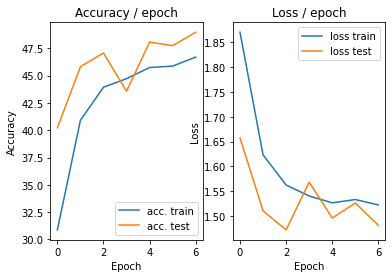

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.173s (0.173s)	Loss 1.5663 (1.5663)	Prec@1  45.3 ( 45.3)	Prec@5  86.7 ( 86.7)


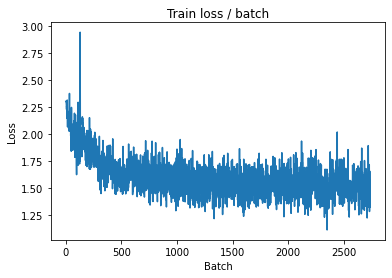

[TRAIN Batch 200/391]	Time 0.038s (0.046s)	Loss 1.6816 (1.5473)	Prec@1  49.2 ( 46.2)	Prec@5  90.6 ( 90.5)


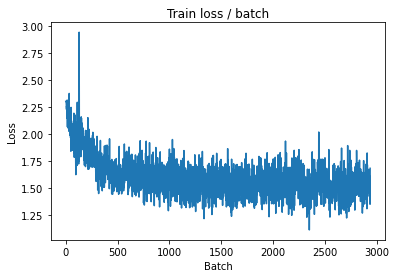


===============> Total time 17s	Avg loss 1.5437	Avg Prec@1 46.22 %	Avg Prec@5 90.31 %

[EVAL Batch 000/079]	Time 0.167s (0.167s)	Loss 1.5222 (1.5222)	Prec@1  41.4 ( 41.4)	Prec@5  92.2 ( 92.2)

===============> Total time 2s	Avg loss 1.5074	Avg Prec@1 48.11 %	Avg Prec@5 91.36 %



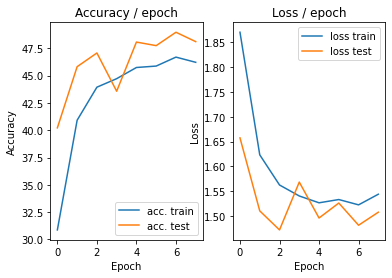

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.217s (0.217s)	Loss 1.3781 (1.3781)	Prec@1  50.0 ( 50.0)	Prec@5  89.8 ( 89.8)


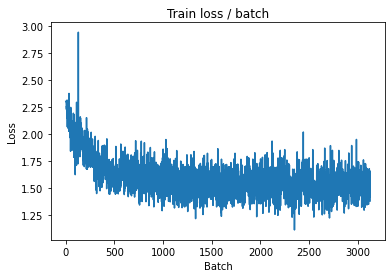

[TRAIN Batch 200/391]	Time 0.061s (0.045s)	Loss 1.4763 (1.5250)	Prec@1  48.4 ( 46.5)	Prec@5  93.0 ( 90.7)


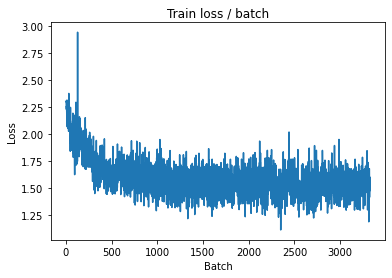


===============> Total time 17s	Avg loss 1.5418	Avg Prec@1 46.02 %	Avg Prec@5 90.38 %

[EVAL Batch 000/079]	Time 0.170s (0.170s)	Loss 1.4566 (1.4566)	Prec@1  50.8 ( 50.8)	Prec@5  90.6 ( 90.6)

===============> Total time 2s	Avg loss 1.4723	Avg Prec@1 48.13 %	Avg Prec@5 91.56 %



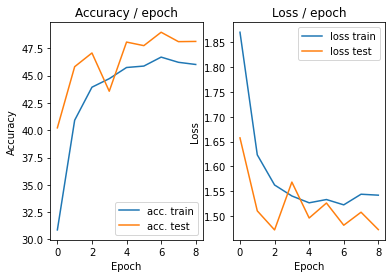

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.216s (0.216s)	Loss 1.8286 (1.8286)	Prec@1  39.8 ( 39.8)	Prec@5  85.9 ( 85.9)


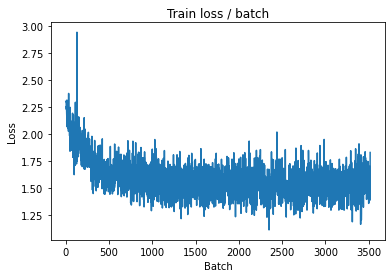

[TRAIN Batch 200/391]	Time 0.059s (0.046s)	Loss 1.5917 (1.4999)	Prec@1  49.2 ( 47.8)	Prec@5  91.4 ( 90.8)


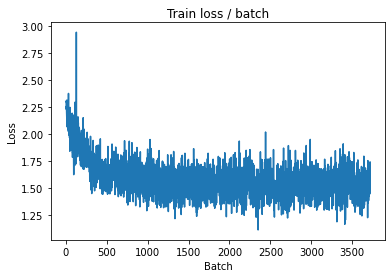


===============> Total time 17s	Avg loss 1.5228	Avg Prec@1 47.01 %	Avg Prec@5 90.53 %

[EVAL Batch 000/079]	Time 0.167s (0.167s)	Loss 1.6289 (1.6289)	Prec@1  43.0 ( 43.0)	Prec@5  85.9 ( 85.9)

===============> Total time 2s	Avg loss 1.6212	Avg Prec@1 43.14 %	Avg Prec@5 88.23 %



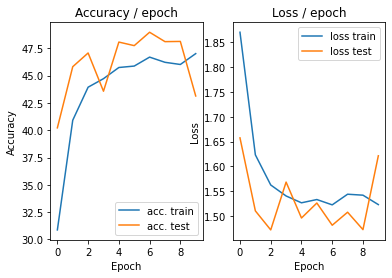

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.209s (0.209s)	Loss 1.5778 (1.5778)	Prec@1  43.8 ( 43.8)	Prec@5  90.6 ( 90.6)


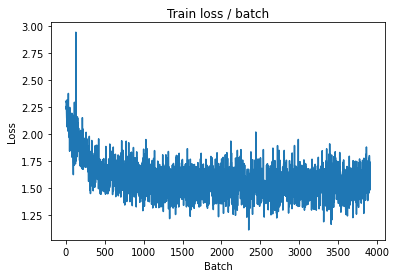

[TRAIN Batch 200/391]	Time 0.075s (0.046s)	Loss 1.6731 (1.5579)	Prec@1  43.0 ( 46.0)	Prec@5  93.0 ( 90.2)


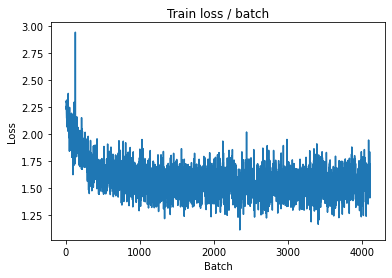


===============> Total time 17s	Avg loss 1.5511	Avg Prec@1 45.98 %	Avg Prec@5 90.42 %

[EVAL Batch 000/079]	Time 0.174s (0.174s)	Loss 1.7697 (1.7697)	Prec@1  41.4 ( 41.4)	Prec@5  86.7 ( 86.7)

===============> Total time 2s	Avg loss 1.5968	Avg Prec@1 43.44 %	Avg Prec@5 89.56 %



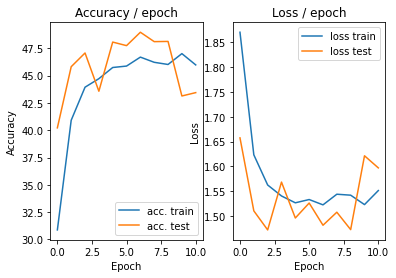

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.213s (0.213s)	Loss 1.6519 (1.6519)	Prec@1  44.5 ( 44.5)	Prec@5  87.5 ( 87.5)


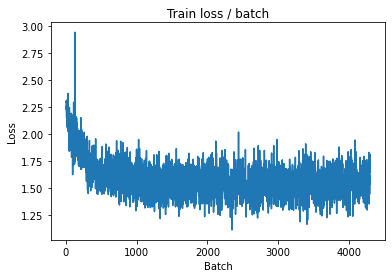

[TRAIN Batch 200/391]	Time 0.061s (0.046s)	Loss 1.5770 (1.5256)	Prec@1  48.4 ( 46.4)	Prec@5  87.5 ( 90.2)


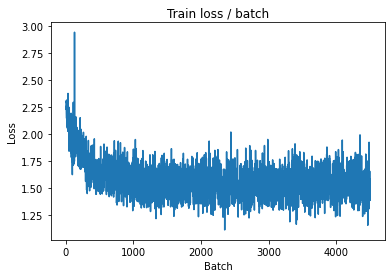


===============> Total time 17s	Avg loss 1.5345	Avg Prec@1 46.18 %	Avg Prec@5 90.30 %

[EVAL Batch 000/079]	Time 0.150s (0.150s)	Loss 1.5342 (1.5342)	Prec@1  44.5 ( 44.5)	Prec@5  90.6 ( 90.6)

===============> Total time 2s	Avg loss 1.5109	Avg Prec@1 47.07 %	Avg Prec@5 91.32 %



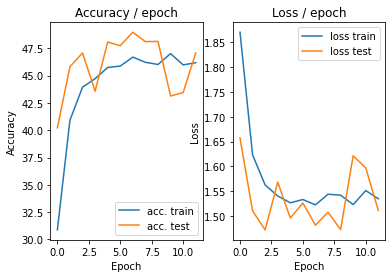

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.208s (0.208s)	Loss 1.2708 (1.2708)	Prec@1  58.6 ( 58.6)	Prec@5  93.8 ( 93.8)


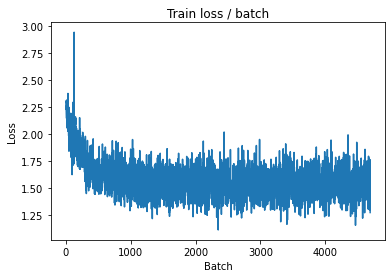

[TRAIN Batch 200/391]	Time 0.053s (0.046s)	Loss 1.6472 (1.5434)	Prec@1  42.2 ( 46.7)	Prec@5  89.8 ( 90.1)


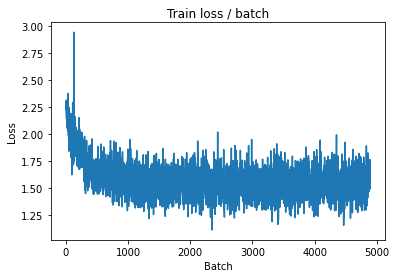


===============> Total time 17s	Avg loss 1.5560	Avg Prec@1 45.96 %	Avg Prec@5 90.15 %

[EVAL Batch 000/079]	Time 0.171s (0.171s)	Loss 1.6132 (1.6132)	Prec@1  43.0 ( 43.0)	Prec@5  89.1 ( 89.1)

===============> Total time 2s	Avg loss 1.5756	Avg Prec@1 44.66 %	Avg Prec@5 90.24 %



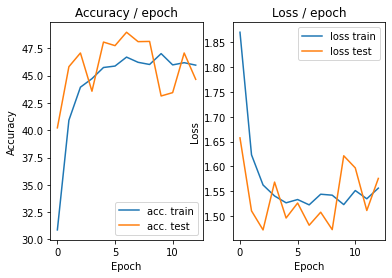

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.198s (0.198s)	Loss 1.5068 (1.5068)	Prec@1  43.0 ( 43.0)	Prec@5  89.1 ( 89.1)


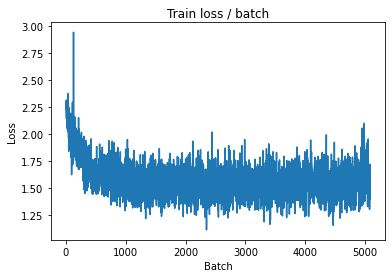

[TRAIN Batch 200/391]	Time 0.016s (0.046s)	Loss 1.5914 (1.5568)	Prec@1  46.9 ( 45.6)	Prec@5  91.4 ( 90.1)


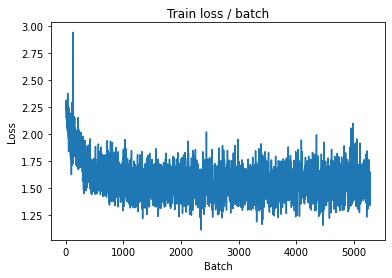


===============> Total time 17s	Avg loss 1.5535	Avg Prec@1 45.75 %	Avg Prec@5 90.03 %

[EVAL Batch 000/079]	Time 0.158s (0.158s)	Loss 1.5681 (1.5681)	Prec@1  43.0 ( 43.0)	Prec@5  90.6 ( 90.6)

===============> Total time 2s	Avg loss 1.5259	Avg Prec@1 45.72 %	Avg Prec@5 89.62 %



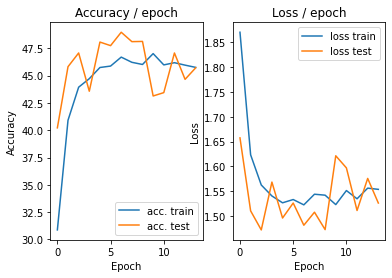

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.190s (0.190s)	Loss 1.5436 (1.5436)	Prec@1  47.7 ( 47.7)	Prec@5  89.1 ( 89.1)


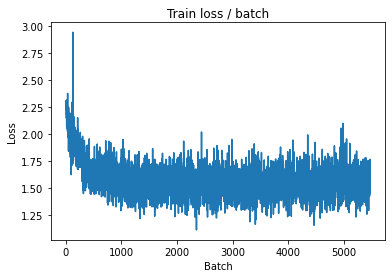

[TRAIN Batch 200/391]	Time 0.070s (0.046s)	Loss 1.5789 (1.5578)	Prec@1  43.0 ( 45.9)	Prec@5  92.2 ( 90.0)


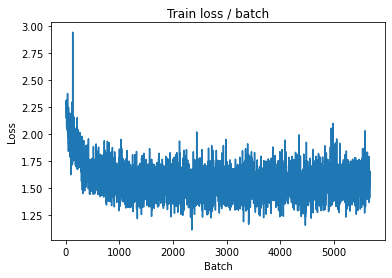


===============> Total time 17s	Avg loss 1.5639	Avg Prec@1 45.60 %	Avg Prec@5 89.94 %

[EVAL Batch 000/079]	Time 0.161s (0.161s)	Loss 1.5093 (1.5093)	Prec@1  46.1 ( 46.1)	Prec@5  91.4 ( 91.4)

===============> Total time 2s	Avg loss 1.5529	Avg Prec@1 45.85 %	Avg Prec@5 90.35 %



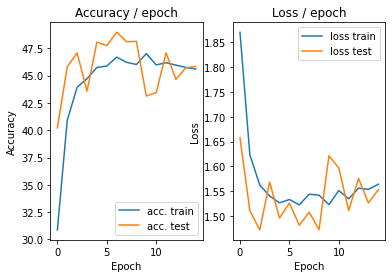

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.220s (0.220s)	Loss 1.6040 (1.6040)	Prec@1  43.8 ( 43.8)	Prec@5  88.3 ( 88.3)


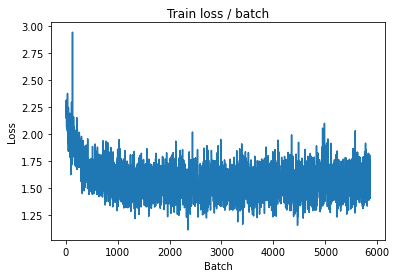

[TRAIN Batch 200/391]	Time 0.058s (0.044s)	Loss 1.5736 (1.5444)	Prec@1  42.2 ( 45.9)	Prec@5  90.6 ( 90.2)


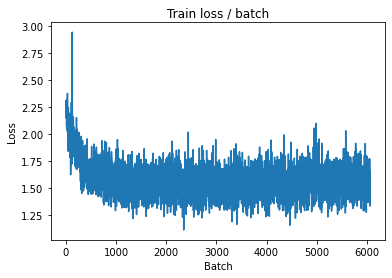


===============> Total time 17s	Avg loss 1.5453	Avg Prec@1 46.11 %	Avg Prec@5 90.20 %

[EVAL Batch 000/079]	Time 0.161s (0.161s)	Loss 1.6281 (1.6281)	Prec@1  44.5 ( 44.5)	Prec@5  93.8 ( 93.8)

===============> Total time 2s	Avg loss 1.5600	Avg Prec@1 47.40 %	Avg Prec@5 91.00 %



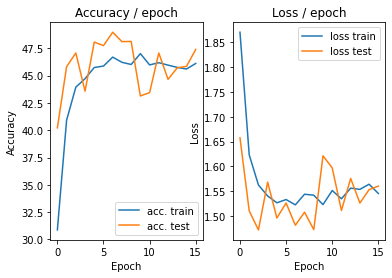

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.197s (0.197s)	Loss 1.6339 (1.6339)	Prec@1  43.0 ( 43.0)	Prec@5  91.4 ( 91.4)


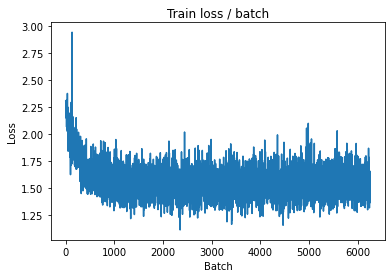

[TRAIN Batch 200/391]	Time 0.063s (0.045s)	Loss 1.3795 (1.5708)	Prec@1  49.2 ( 45.6)	Prec@5  93.8 ( 89.6)


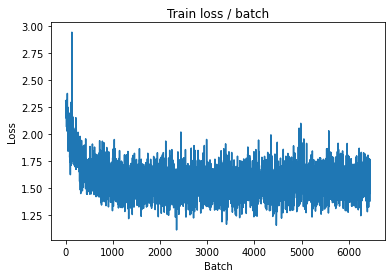


===============> Total time 17s	Avg loss 1.5584	Avg Prec@1 45.90 %	Avg Prec@5 89.92 %

[EVAL Batch 000/079]	Time 0.152s (0.152s)	Loss 1.5028 (1.5028)	Prec@1  47.7 ( 47.7)	Prec@5  90.6 ( 90.6)

===============> Total time 2s	Avg loss 1.5239	Avg Prec@1 48.13 %	Avg Prec@5 90.39 %



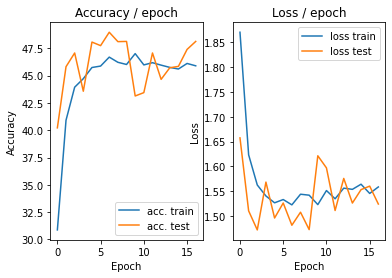

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.200s (0.200s)	Loss 1.3143 (1.3143)	Prec@1  56.2 ( 56.2)	Prec@5  90.6 ( 90.6)


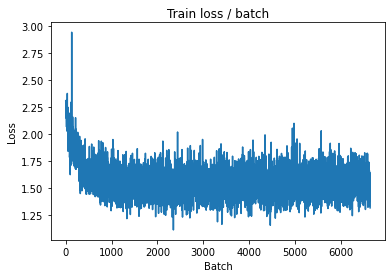

[TRAIN Batch 200/391]	Time 0.056s (0.044s)	Loss 1.6094 (1.5693)	Prec@1  48.4 ( 45.2)	Prec@5  88.3 ( 89.6)


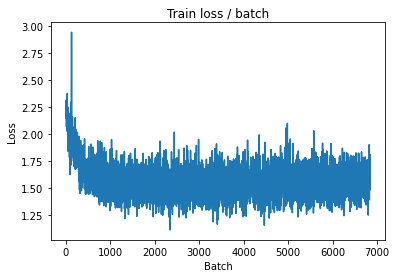


===============> Total time 17s	Avg loss 1.5731	Avg Prec@1 44.97 %	Avg Prec@5 89.73 %

[EVAL Batch 000/079]	Time 0.211s (0.211s)	Loss 1.5298 (1.5298)	Prec@1  48.4 ( 48.4)	Prec@5  89.1 ( 89.1)

===============> Total time 2s	Avg loss 1.5474	Avg Prec@1 46.14 %	Avg Prec@5 90.60 %



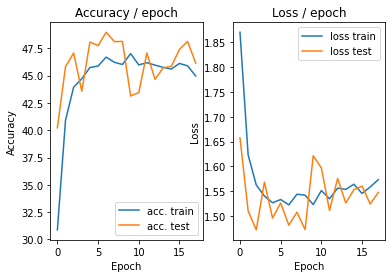

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.201s (0.201s)	Loss 1.5541 (1.5541)	Prec@1  53.1 ( 53.1)	Prec@5  91.4 ( 91.4)


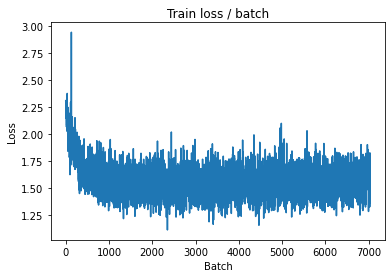

[TRAIN Batch 200/391]	Time 0.077s (0.045s)	Loss 1.6904 (1.5735)	Prec@1  46.1 ( 45.4)	Prec@5  87.5 ( 89.7)


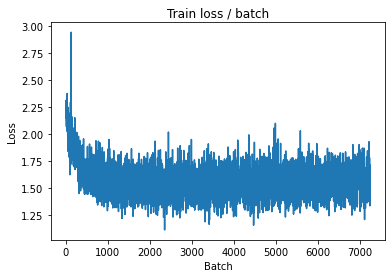


===============> Total time 17s	Avg loss 1.5802	Avg Prec@1 44.93 %	Avg Prec@5 89.69 %

[EVAL Batch 000/079]	Time 0.162s (0.162s)	Loss 1.5876 (1.5876)	Prec@1  50.8 ( 50.8)	Prec@5  90.6 ( 90.6)

===============> Total time 2s	Avg loss 1.5582	Avg Prec@1 45.78 %	Avg Prec@5 90.57 %



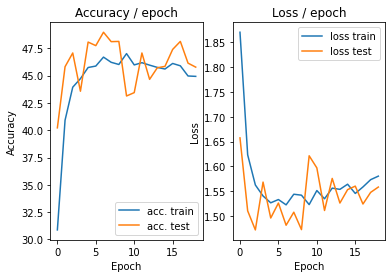

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.191s (0.191s)	Loss 1.5525 (1.5525)	Prec@1  46.9 ( 46.9)	Prec@5  86.7 ( 86.7)


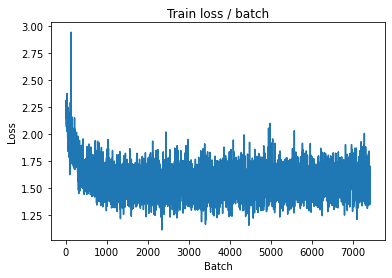

[TRAIN Batch 200/391]	Time 0.062s (0.045s)	Loss 1.4474 (1.5908)	Prec@1  48.4 ( 44.6)	Prec@5  93.0 ( 89.2)


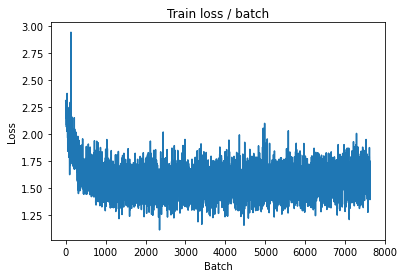


===============> Total time 17s	Avg loss 1.5592	Avg Prec@1 45.68 %	Avg Prec@5 89.88 %

[EVAL Batch 000/079]	Time 0.179s (0.179s)	Loss 1.5755 (1.5755)	Prec@1  41.4 ( 41.4)	Prec@5  92.2 ( 92.2)

===============> Total time 2s	Avg loss 1.5120	Avg Prec@1 46.34 %	Avg Prec@5 91.16 %



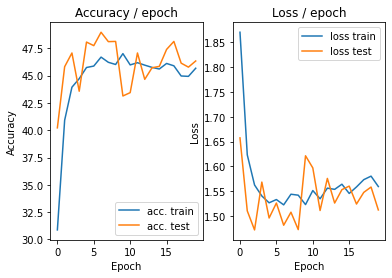

In [29]:
main5(128, 0.1, epochs=20 ,cuda=True)

#### avec décroissance exponentielle (learning rate schedular)

In [45]:
class ConvNet6(nn.Module):
    """
    Cette classe contient la structure du réseau de neurones
    """

    def __init__(self):
        super(ConvNet6, self).__init__()
        # On défini d'abord les couches de convolution et de pooling comme un
        # groupe de couches `self.features`
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),
        )
        # On défini les couches fully connected comme un groupe de couches
        # `self.classifier`
        self.classifier = nn.Sequential(
            nn.Linear(4*4*64, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Rappel : Le softmax est inclus dans la loss, ne pas le mettre ici
        )

    # méthode appelée quand on applique le réseau à un batch d'input
    def forward(self, input):
        bsize = input.size(0) # taille du batch
        output = self.features(input) # on calcule la sortie des conv

        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input

        output = self.classifier(output) # on calcule la sortie des fc
        return output



def get_dataset(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et effectue des transformations sur chaqu
    image (listées dans `transform=...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201]),
            transforms.RandomCrop(28),
            transforms.RandomHorizontalFlip(),
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201]),
            transforms.CenterCrop(28),
 
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # si on fait du GPU, passage en CUDA
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss

def main6(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex de params :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet6()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
    lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


    if cuda: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # On récupère les données
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Phase d'evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

        lr_sched.step()

In [46]:
main6(128, 0.1, epochs=35 ,cuda=True)

Output hidden; open in https://colab.research.google.com to view.

### 3.4 Régularisation du réseau par dropout

In [47]:
class ConvNet7(nn.Module):
    """
    Cette classe contient la structure du réseau de neurones
    """

    def __init__(self):
        super(ConvNet7, self).__init__()
        # On défini d'abord les couches de convolution et de pooling comme un
        # groupe de couches `self.features`
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),
        )
        # On défini les couches fully connected comme un groupe de couches
        # `self.classifier`
        self.classifier = nn.Sequential(
            nn.Linear(4*4*64, 1000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1000, 10),
            # Rappel : Le softmax est inclus dans la loss, ne pas le mettre ici
        )

    # méthode appelée quand on applique le réseau à un batch d'input
    def forward(self, input):
        bsize = input.size(0) # taille du batch
        output = self.features(input) # on calcule la sortie des conv

        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input

        output = self.classifier(output) # on calcule la sortie des fc
        return output



def get_dataset(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et effectue des transformations sur chaqu
    image (listées dans `transform=...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201]),
            transforms.RandomCrop(28),
            transforms.RandomHorizontalFlip(),
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201]),
            transforms.CenterCrop(28),
 
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # si on fait du GPU, passage en CUDA
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss

def main7(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex de params :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet7()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
    lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


    if cuda: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # On récupère les données
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Phase d'evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

        lr_sched.step()

In [48]:
main7(128, 0.1, epochs=35 ,cuda=True)

Output hidden; open in https://colab.research.google.com to view.

### 3.5 Utilisation de batch normalization

In [36]:
class ConvNet8(nn.Module):
    """
    Cette classe contient la structure du réseau de neurones
    """

    def __init__(self):
        super(ConvNet8, self).__init__()
        # On défini d'abord les couches de convolution et de pooling comme un
        # groupe de couches `self.features`
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),
        )
        # On défini les couches fully connected comme un groupe de couches
        # `self.classifier`
        self.classifier = nn.Sequential(
            nn.Linear(4*4*64, 1000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1000, 10),
            # Rappel : Le softmax est inclus dans la loss, ne pas le mettre ici
        )

    # méthode appelée quand on applique le réseau à un batch d'input
    def forward(self, input):
        bsize = input.size(0) # taille du batch
        output = self.features(input) # on calcule la sortie des conv

        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input

        output = self.classifier(output) # on calcule la sortie des fc
        return output



def get_dataset(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et effectue des transformations sur chaqu
    image (listées dans `transform=...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201]),
            transforms.RandomCrop(28),
            transforms.RandomHorizontalFlip(),
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std =[0.202, 0.199, 0.201]),
            transforms.CenterCrop(28),
 
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # si on fait du GPU, passage en CUDA
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss

def main8(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex de params :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet8()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
    lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


    if cuda: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # On récupère les données
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Phase d'evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

        lr_sched.step()

In [38]:
main8(128, 0.1, epochs=35 ,cuda=True)

Output hidden; open in https://colab.research.google.com to view.